In [67]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lecilab_behavior_analysis.df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import warnings
warnings.filterwarnings('ignore')


# Data Import

In [3]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['auditory_escape_data', 'cate_task_data', 'COT_cannula_data', 'COT_test_data', 'visual_and_COT_data']


In [4]:
project = "visual_and_COT_data"

## single mouse data import

In [6]:
# see the available animals
animals = utils.get_animals_in_project(project)
print(animals)
# download the data for a specific animal
mouse = "ACV008"
local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_cluster_data(
    project_name=project,
    file_path="sessions/{}/{}.csv".format(mouse, mouse),
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'prueba', 'punish_test', 'test', 'test2']


receiving incremental file list
ACV008.csv

sent 118,977 bytes  received 26,587,224 bytes  1,136,434.09 bytes/sec
total size is 466,592,375  speedup is 17.47


## multiple mice data import

In [5]:
# run this if you want to pull data from several animals
acv_animals = [f"ACV{str(i).zfill(3)}" for i in range(1, 11)]

df_dic = {}
for mouse in acv_animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name=project,
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
    # load the data
    df_single = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_dic[mouse] = df_single


receiving incremental file list

sent 20 bytes  received 73 bytes  37.20 bytes/sec
total size is 553,938,026  speedup is 5,956,322.86


receiving incremental file list

sent 20 bytes  received 74 bytes  37.60 bytes/sec
total size is 495,635,722  speedup is 5,272,720.45


receiving incremental file list

sent 20 bytes  received 74 bytes  37.60 bytes/sec
total size is 535,186,755  speedup is 5,693,476.12


receiving incremental file list

sent 20 bytes  received 74 bytes  37.60 bytes/sec
total size is 453,793,098  speedup is 4,827,586.15


receiving incremental file list

sent 20 bytes  received 74 bytes  37.60 bytes/sec
total size is 425,198,507  speedup is 4,523,388.37


receiving incremental file list

sent 20 bytes  received 73 bytes  37.20 bytes/sec
total size is 511,593,330  speedup is 5,501,003.55


receiving incremental file list

sent 20 bytes  received 74 bytes  26.86 bytes/sec
total size is 501,171,573  speedup is 5,331,612.48


receiving incremental file list

sent 20 bytes  received 73 bytes  37.20 bytes/sec
total size is 466,592,375  speedup is 5,017,122.31


receiving incremental file list

sent 20 bytes  received 74 bytes  37.60 bytes/sec
total size is 608,667,685  speedup is 6,475,188.14


receiving incremental file list

sent 20 bytes  received 74 bytes  26.86 bytes/sec
total size is 501,401,118  speedup is 5,334,054.45


In [6]:
df_dic_hard_vis = {}
df_dic_hard_aud = {}
df_test_visual = pd.DataFrame()
df_test_auditory = pd.DataFrame()
for mouse in df_dic:
    df_dic[mouse] = dft.analyze_df(df_dic[mouse])
    df_dic_hard_vis[mouse] = df_dic[mouse][df_dic[mouse]["current_training_stage"] == "TwoAFC_visual_hard"]
    df_dic_hard_vis[mouse] = dft.parameters_for_fit(df_dic_hard_vis[mouse])
    df_test_visual = pd.concat([df_test_visual, df_dic_hard_vis[mouse]], ignore_index=True)
    df_dic_hard_aud[mouse] = df_dic[mouse][df_dic[mouse]["current_training_stage"] == "TwoAFC_auditory_hard"]
    df_dic_hard_aud[mouse] = dft.parameters_for_fit(df_dic_hard_aud[mouse])
    df_test_auditory = pd.concat([df_test_auditory, df_dic_hard_aud[mouse]], ignore_index=True)

# psychometric curve test

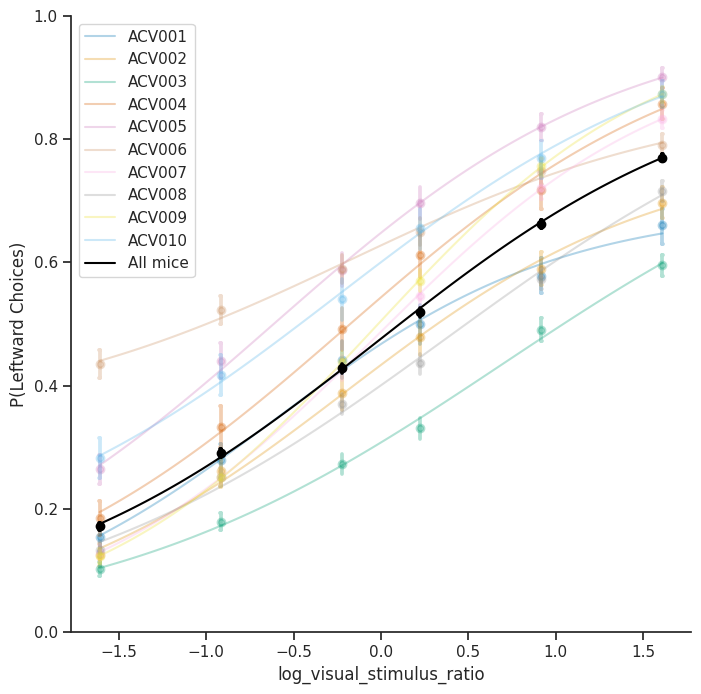

In [98]:
plt.figure(figsize=(8, 8))
for df_name, df, color in zip(df_dic_hard_vis.keys(), df_dic_hard_vis.values(), sns.color_palette("colorblind", len(df_dic_hard_vis))):
    plots.psychometric_plot(df, x='visual_stimulus_ratio', y='first_choice_numeric', point_kwargs={'color': color, 'label' : '', 'alpha': 0.3}, line_kwargs={'color': color, 'label': df_name, 'alpha': 0.3})
plots.psychometric_plot(df_test_visual, x = 'visual_stimulus_ratio', y = 'first_choice_numeric', point_kwargs={'color': 'black', 'label' : ''}, line_kwargs={'color': 'black', 'label': 'All mice'})
plt.show()

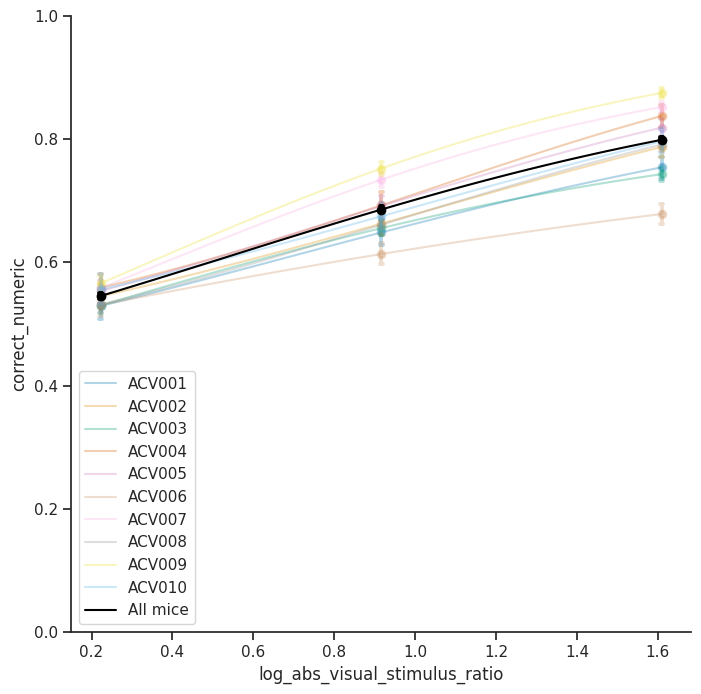

In [26]:
plt.figure(figsize=(8, 8))
for df_name, df, color in zip(df_dic_hard_vis.keys(), df_dic_hard_vis.values(), sns.color_palette("colorblind", len(df_dic_hard_vis))):
    plots.psychometric_plot(df, x='abs_visual_stimulus_ratio', y='correct_numeric', point_kwargs={'color': color, 'label' : '', 'alpha': 0.3}, line_kwargs={'color': color, 'label': df_name, 'alpha': 0.3})
plots.psychometric_plot(df_test_visual, x = 'abs_visual_stimulus_ratio', y = 'correct_numeric', point_kwargs={'color': 'black', 'label' : ''}, line_kwargs={'color': 'black', 'label': 'All mice'})
plt.show()

In [108]:
def rescale_to_range(x, new_min=0, new_max=1):
    x = np.array(x, dtype=float)
    old_min, old_max = np.min(x), np.max(x)
    x_scaled = (x - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return x_scaled

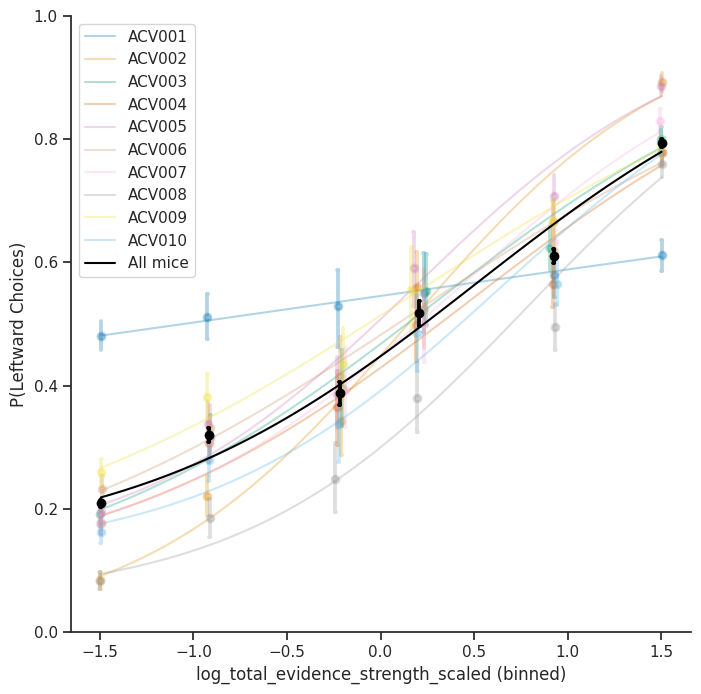

In [110]:
plt.figure(figsize=(8, 8))
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    df['total_evidence_strength_scaled'] = rescale_to_range(df['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
    plots.psychometric_plot(df, x='total_evidence_strength_scaled', y='first_choice_numeric', valueType='continue', point_kwargs={'color': color, 'label' : '', 'alpha': 0.3}, line_kwargs={'color': color, 'label': df_name, 'alpha': 0.3})
df_test_auditory['total_evidence_strength_scaled'] = rescale_to_range(df_test_auditory['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
plots.psychometric_plot(df_test_auditory, x = 'total_evidence_strength_scaled', y = 'first_choice_numeric', valueType='continue', point_kwargs={'color': 'black', 'label' : ''}, line_kwargs={'color': 'black', 'label': 'All mice'})
plt.show()

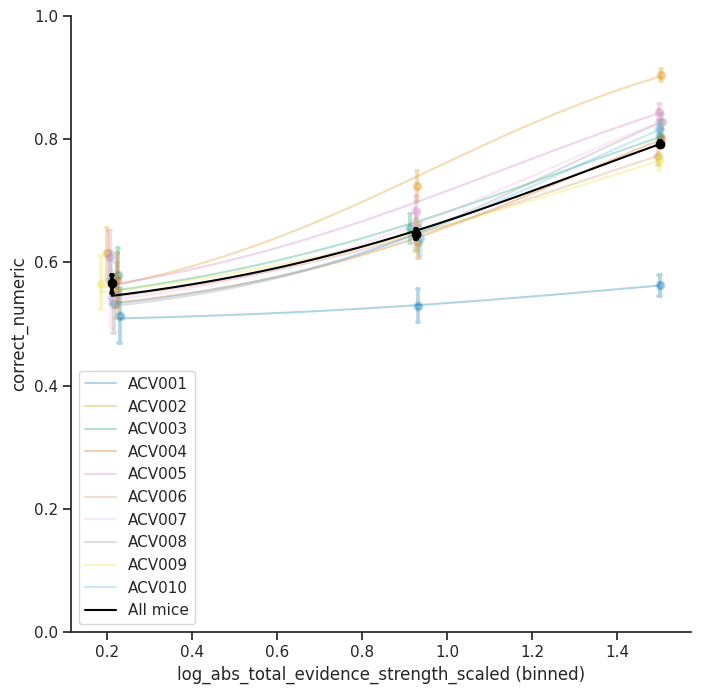

In [112]:
plt.figure(figsize=(8, 8))
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    df['total_evidence_strength_scaled'] = rescale_to_range(df['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
    df['abs_total_evidence_strength_scaled'] = df['total_evidence_strength_scaled'].abs()
    plots.psychometric_plot(df, x='abs_total_evidence_strength_scaled', y='correct_numeric', valueType='continue', bins=3, point_kwargs={'color': color, 'label' : '', 'alpha': 0.3}, line_kwargs={'color': color, 'label': df_name, 'alpha': 0.3})
df_test_auditory['total_evidence_strength_scaled'] = rescale_to_range(df_test_auditory['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
df_test_auditory['abs_total_evidence_strength_scaled'] = df_test_auditory['total_evidence_strength_scaled'].abs()
plots.psychometric_plot(df_test_auditory, x = 'abs_total_evidence_strength_scaled', y = 'correct_numeric', valueType='continue', bins=3, point_kwargs={'color': 'black', 'label' : ''}, line_kwargs={'color': 'black', 'label': 'All mice'})
plt.show()

In [116]:
lapse_left_list_vis = []
lapse_right_list_vis = []
beta_list_vis = []
x0_list_vis = []
for mouse in df_dic_hard_vis:
    y, params = utils.psychometric_curve_fitting_params(df_dic_hard_vis[mouse], x = 'visual_stimulus_ratio', y = 'first_choice_numeric')
    (lapse_left, lapse_right, beta, x0) = params
    lapse_left_list_vis.append(lapse_left)
    lapse_right_list_vis.append(lapse_right)
    beta_list_vis.append(beta)
    x0_list_vis.append(x0)
    
lapse_left_list_aud = []
lapse_right_list_aud = []
beta_list_aud = []
x0_list_aud = []
for mouse in df_dic_hard_aud:
    df_dic_hard_aud[mouse]['total_evidence_strength_scaled'] = rescale_to_range(df_dic_hard_aud[mouse]['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
    y, params = utils.psychometric_curve_fitting_params(df_dic_hard_aud[mouse], x = 'total_evidence_strength_scaled', y = 'first_choice_numeric', valueType='continue', bins=6)
    (lapse_left, lapse_right, beta, x0) = params
    lapse_left_list_aud.append(lapse_left)
    lapse_right_list_aud.append(lapse_right)
    beta_list_aud.append(beta)
    x0_list_aud.append(x0)

In [117]:
params_vis = pd.DataFrame({
            'lapse_left': lapse_left_list_vis,
            'lapse_right': lapse_right_list_vis,
            'beta': beta_list_vis,
            'x0': x0_list_vis
            })
params_vis['condition'] = 'Visual'

params_aud = pd.DataFrame({
            'lapse_left': lapse_left_list_aud,
            'lapse_right': lapse_right_list_aud,
            'beta': beta_list_aud,
            'x0': x0_list_aud
            })
params_aud['condition'] = 'Auditory'

params_df = pd.concat([params_vis, params_aud], ignore_index=True)

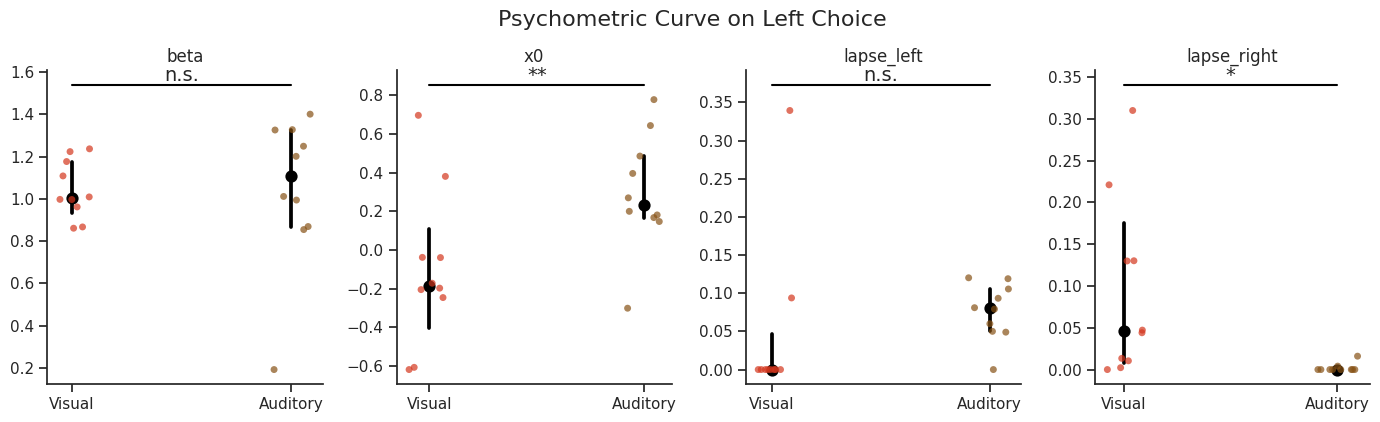

In [118]:
plots.plot_param_comparison(
    df=params_df,
    params=['beta', 'x0', 'lapse_left', 'lapse_right'],
    conditions=['Visual', 'Auditory'],
    test='paired_t',
    title='Psychometric Curve on Left Choice',
    palette=["#D4361D", "#875215"]
)

In [124]:
df_test_visual['visual_stimulus']

0            (0.5162206099313748, 0.10324412198627496)
1           (0.24108079718080433, 0.19286463774464346)
2            (0.1748277674827346, 0.13986221398618767)
3           (0.12039353652573954, 0.09631482922059163)
4            (0.9353103854384837, 0.18706207708769673)
                              ...                     
113210       (0.1226834305255923, 0.09814674442047384)
113211       (0.8123942243510562, 0.16247884487021125)
113212    (0.061877192774476626, 0.012375438554895325)
113213      (0.47025688519105663, 0.09405137703821133)
113214       (0.2636083197283661, 0.05272166394567322)
Name: visual_stimulus, Length: 113215, dtype: object

In [119]:
lapse_hard_list_vis = []
lapse_easy_list_vis = []
beta_list_vis = []
x0_list_vis = []
for mouse in df_dic_hard_vis:
    y, params = utils.psychometric_curve_fitting_params(df_dic_hard_vis[mouse], x = 'abs_visual_stimulus_ratio', y = 'correct_numeric')
    (lapse_hard, lapse_easy, beta, x0) = params
    lapse_hard_list_vis.append(lapse_hard)
    lapse_easy_list_vis.append(lapse_easy)
    beta_list_vis.append(beta)
    x0_list_vis.append(x0)

lapse_hard_list_aud = []
lapse_easy_list_aud = []
beta_list_aud = []
x0_list_aud = []
for mouse in df_dic_hard_aud:
    df_dic_hard_aud[mouse]['total_evidence_strength_scaled'] = rescale_to_range(df_dic_hard_aud[mouse]['total_evidence_strength'], new_min=df_test_visual['visual_stimulus_ratio'].min(), new_max=df_test_visual['visual_stimulus_ratio'].max())
    df_dic_hard_aud[mouse]['abs_total_evidence_strength_scaled'] = df_dic_hard_aud[mouse]['total_evidence_strength_scaled'].abs()
    y, params = utils.psychometric_curve_fitting_params(df_dic_hard_aud[mouse], x = 'abs_total_evidence_strength_scaled', y = 'correct_numeric', valueType='continue', bins=3)
    (lapse_hard, lapse_easy, beta, x0) = params
    lapse_hard_list_aud.append(lapse_hard)
    lapse_easy_list_aud.append(lapse_easy)
    beta_list_aud.append(beta)
    x0_list_aud.append(x0)

In [120]:
params_vis = pd.DataFrame({
            'lapse_hard': lapse_hard_list_vis,
            'lapse_easy': lapse_easy_list_vis,
            'beta': beta_list_vis,
            'x0': x0_list_vis
            })
params_vis['condition'] = 'Visual'

params_aud = pd.DataFrame({
            'lapse_hard': lapse_hard_list_aud,
            'lapse_easy': lapse_easy_list_aud,
            'beta': beta_list_aud,
            'x0': x0_list_aud
            })
params_aud['condition'] = 'Auditory'

params_df = pd.concat([params_vis, params_aud], ignore_index=True)

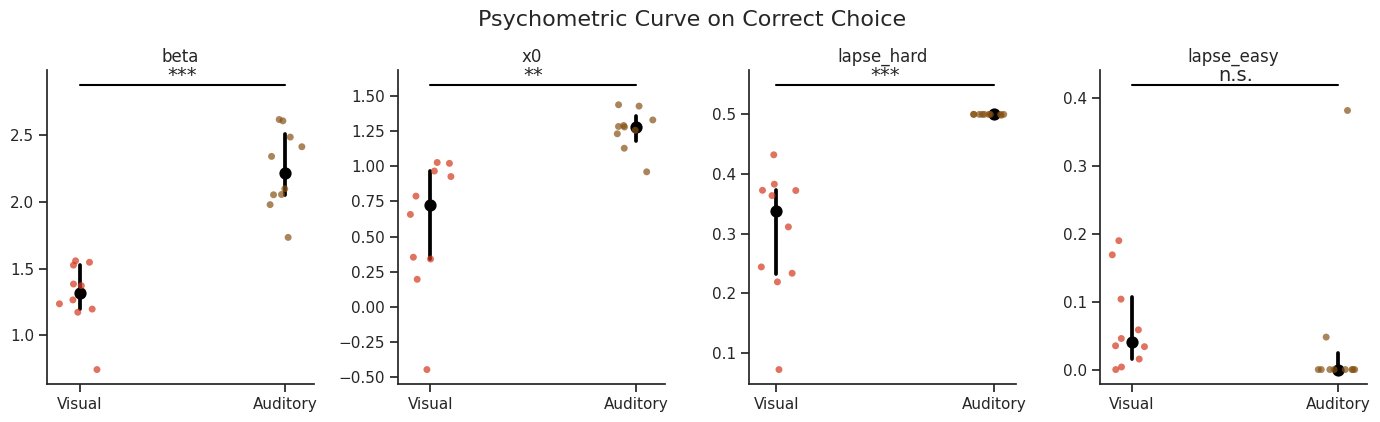

In [121]:
plots.plot_param_comparison(
    df=params_df,
    params=['beta', 'x0', 'lapse_hard', 'lapse_easy'],
    conditions=['Visual', 'Auditory'],
    test='paired_t',
    title='Psychometric Curve on Correct Choice',
    palette=["#D4361D", "#875215"]
)

# Correct wrong psychometric curve

Text(0.5, 1.0, 'Right Choice Previous')

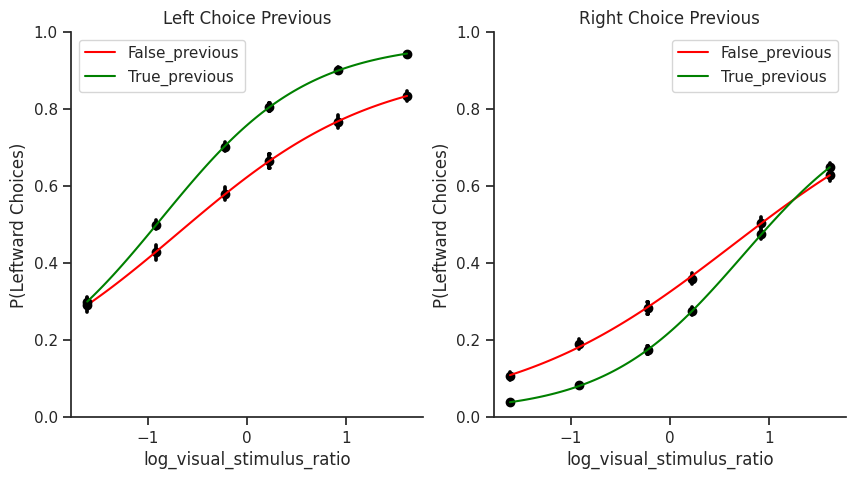

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test_visual[df_test_visual['previous_port_before_stimulus'] == 'left'].groupby('previous_correct_numeric'), ['red', 'green']):
    plots.psychometric_plot(i[1], x = 'visual_stimulus_ratio', y = 'first_choice_numeric',
                            line_kwargs={'color': linecolor,
                                         'label': 'True_previous' if i[0] == 1 else 'False_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[0])

for i, linecolor in zip(df_test_visual[df_test_visual['previous_port_before_stimulus'] == 'right'].groupby('previous_correct_numeric'), ['red', 'green']):
    plots.psychometric_plot(i[1], x = 'visual_stimulus_ratio', y = 'first_choice_numeric',
                            line_kwargs={'color': linecolor,
                                         'label': 'True_previous' if i[0] == 1 else 'False_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[1])
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

Text(0.5, 1.0, 'Right Choice Previous')

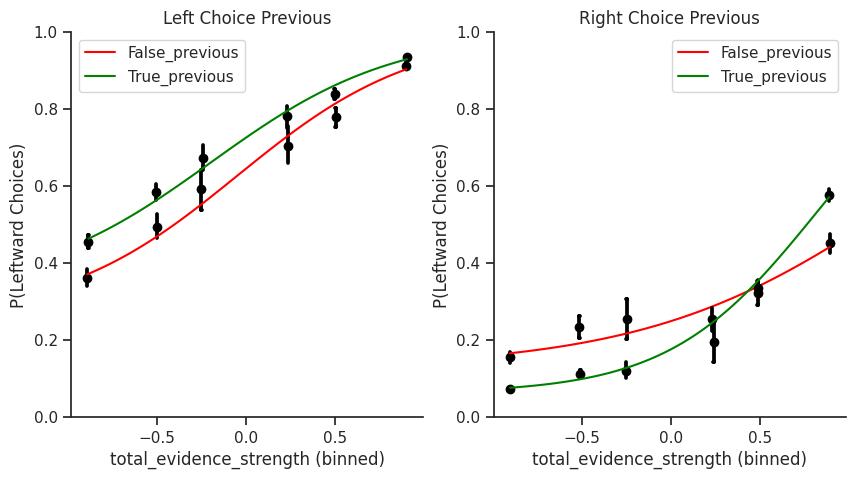

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test_auditory[df_test_auditory['previous_port_before_stimulus'] == 'left'].groupby('previous_correct_numeric'), ['red', 'green']):
    plots.psychometric_plot(i[1], x = 'total_evidence_strength', y = 'first_choice_numeric', valueType='continue',
                            line_kwargs={'color': linecolor,
                                         'label': 'True_previous' if i[0] == 1 else 'False_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[0])

for i, linecolor in zip(df_test_auditory[df_test_auditory['previous_port_before_stimulus'] == 'right'].groupby('previous_correct_numeric'), ['red', 'green']):
    plots.psychometric_plot(i[1], x = 'total_evidence_strength', y = 'first_choice_numeric', valueType='continue',
                            line_kwargs={'color': linecolor,
                                         'label': 'True_previous' if i[0] == 1 else 'False_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[1])
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

Text(0.5, 1.0, 'Incorrect Choice Previous')

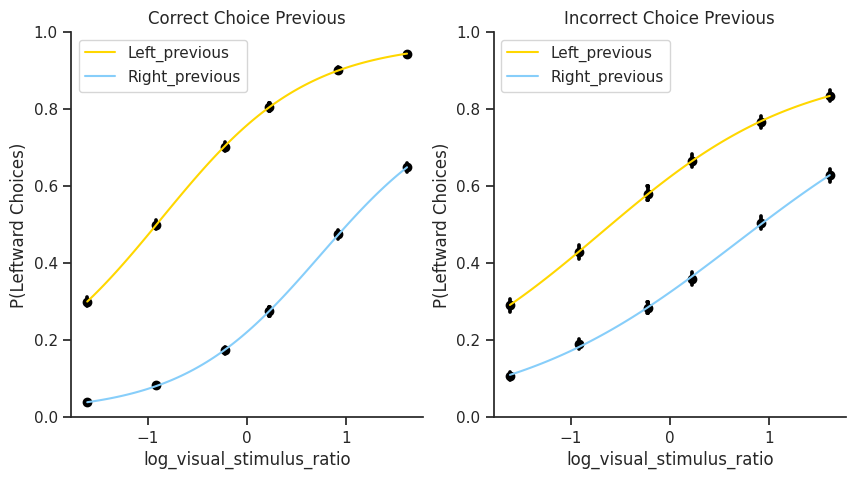

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test_visual[df_test_visual['previous_correct_numeric'] == 1].groupby('previous_port_before_stimulus'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(df = i[1], x = 'visual_stimulus_ratio', y = 'first_choice_numeric', 
                            line_kwargs={'color': linecolor,
                                         'label': 'Left_previous' if i[0] == 'left' else 'Right_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[0])

for i, linecolor in zip(df_test_visual[df_test_visual['previous_correct_numeric'] == 0].groupby('previous_port_before_stimulus'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(df = i[1], x = 'visual_stimulus_ratio', y = 'first_choice_numeric', 
                            line_kwargs={'color': linecolor,
                                         'label': 'Left_previous' if i[0] == 'left' else 'Right_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[1])
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

Text(0.5, 1.0, 'Incorrect Choice Previous')

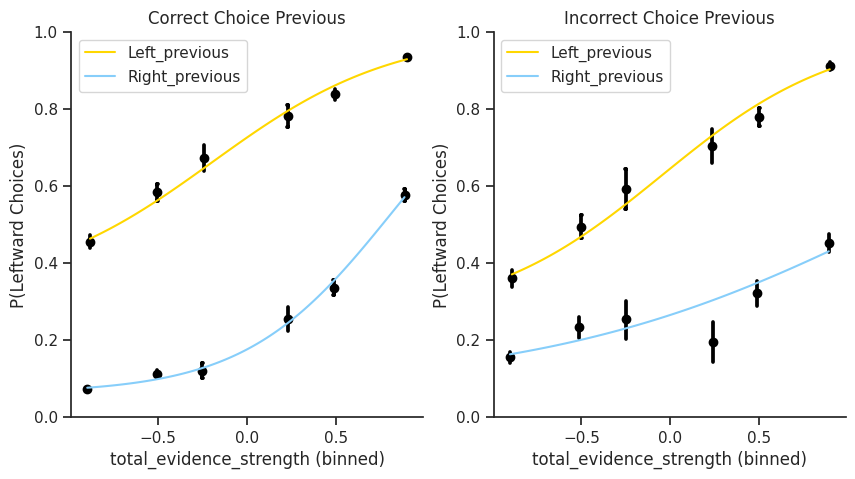

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test_auditory[df_test_auditory['previous_correct_numeric'] == 1].groupby('previous_port_before_stimulus'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(i[1], x = 'total_evidence_strength', y = 'first_choice_numeric', valueType='continue',
                            line_kwargs={'color': linecolor,
                                         'label': 'Left_previous' if i[0] == 'left' else 'Right_previous'}, 
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[0])
    
for i, linecolor in zip(df_test_auditory[df_test_auditory['previous_correct_numeric'] == 0].groupby('previous_port_before_stimulus'), ['gold', 'lightskyblue']):
    plots.psychometric_plot(i[1], x = 'total_evidence_strength', y = 'first_choice_numeric', valueType='continue',
                            line_kwargs={'color': linecolor,
                                         'label': 'Left_previous' if i[0] == 'left' else 'Right_previous'},
                            point_kwargs={'color': 'black', 'label': None},
                            ax=ax[1])
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

# Matrix format

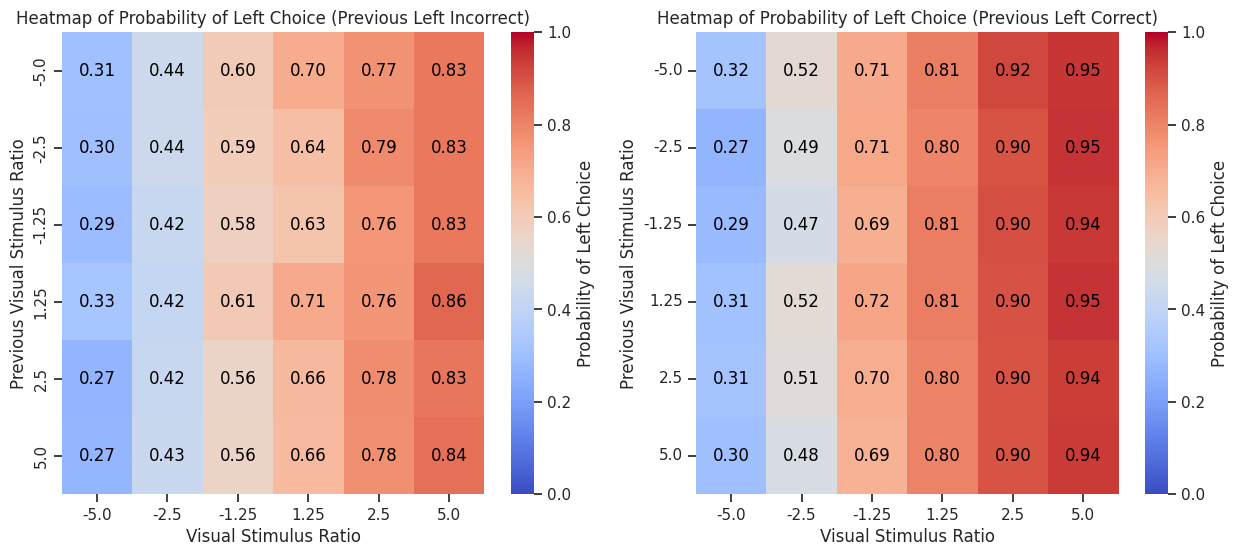

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i in df_test_visual[(df_test_visual['previous_port_before_stimulus'] == 'left')].groupby('previous_correct_numeric'):
    df_preleft = i[1]
    df_preleft['visual_stimulus_ratio'] = df_preleft['visual_stimulus_ratio'].apply(lambda x: round(x, 2))
    for mouse in df_preleft['subject'].unique():
        for session in df_preleft[df_preleft.subject == mouse]['session'].unique():
            df_mouse_session = df_preleft[np.logical_and(df_preleft['subject'] == mouse, df_preleft['session'] == session)]
            df_mouse_session['previous_visual_stimulus_ratio'] = df_mouse_session['visual_stimulus_ratio'].shift(1, fill_value=np.nan)
            df_preleft.loc[df_mouse_session.index, 'previous_visual_stimulus_ratio'] = df_mouse_session['previous_visual_stimulus_ratio']
    pivot_table = df_preleft.pivot_table(
        index='previous_visual_stimulus_ratio',
        columns='visual_stimulus_ratio',
        values='first_choice_numeric',
        aggfunc='mean',
        observed=True
    )
    # plot the heatmap
    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"}, ax=axes[i[0]])
    axes[i[0]].set_xlabel("Visual Stimulus Ratio")
    axes[i[0]].set_ylabel("Previous Visual Stimulus Ratio")
    axes[i[0]].set_title("Heatmap of Probability of Left Choice (Previous Left {})".format('Correct' if i[0] == 1 else 'Incorrect'))
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.show()

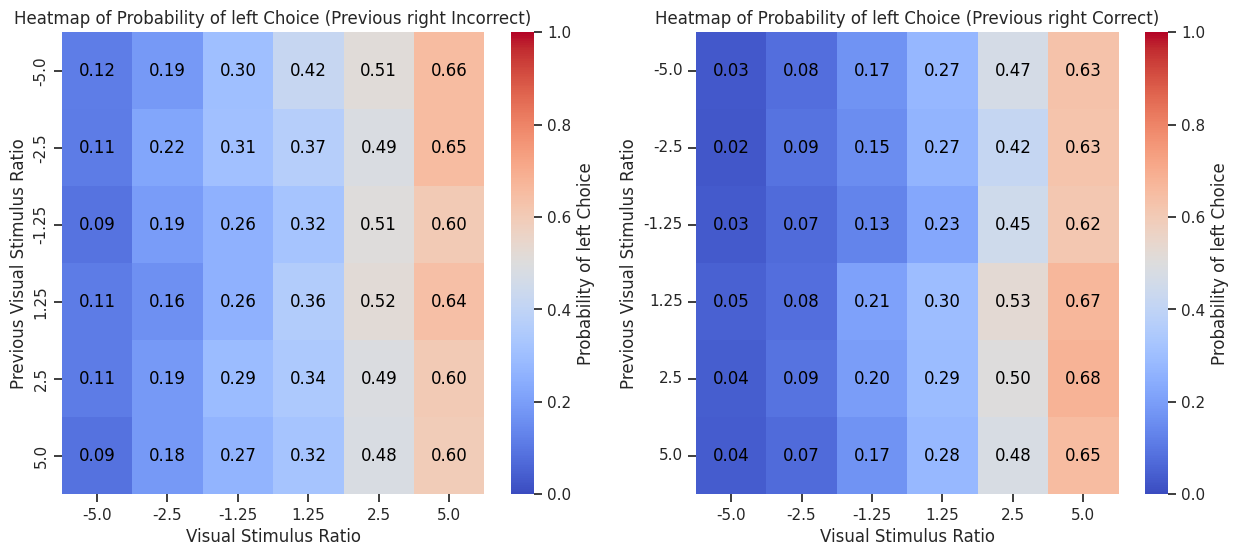

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i in df_test_visual[(df_test_visual['previous_port_before_stimulus'] == 'right')].groupby('previous_correct_numeric'):
    df_preright = i[1]
    df_preright['visual_stimulus_ratio'] = df_preright['visual_stimulus_ratio'].apply(lambda x: round(x, 2))
    for mouse in df_preright['subject'].unique():
        for session in df_preright[df_preright.subject == mouse]['session'].unique():
            df_mouse_session = df_preright[np.logical_and(df_preright['subject'] == mouse, df_preright['session'] == session)]
            df_mouse_session['previous_visual_stimulus_ratio'] = df_mouse_session['visual_stimulus_ratio'].shift(1, fill_value=np.nan)
            df_preright.loc[df_mouse_session.index, 'previous_visual_stimulus_ratio'] = df_mouse_session['previous_visual_stimulus_ratio']
    pivot_table = df_preright.pivot_table(
        index='previous_visual_stimulus_ratio',
        columns='visual_stimulus_ratio',
        values='first_choice_numeric',
        aggfunc='mean',
        observed=True
    )
    # plot the heatmap
    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"}, ax=axes[i[0]])
    axes[i[0]].set_xlabel("Visual Stimulus Ratio")
    axes[i[0]].set_ylabel("Previous Visual Stimulus Ratio")
    axes[i[0]].set_title("Heatmap of Probability of left Choice (Previous right {})".format('Correct' if i[0] == 1 else 'Incorrect'))
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.show()

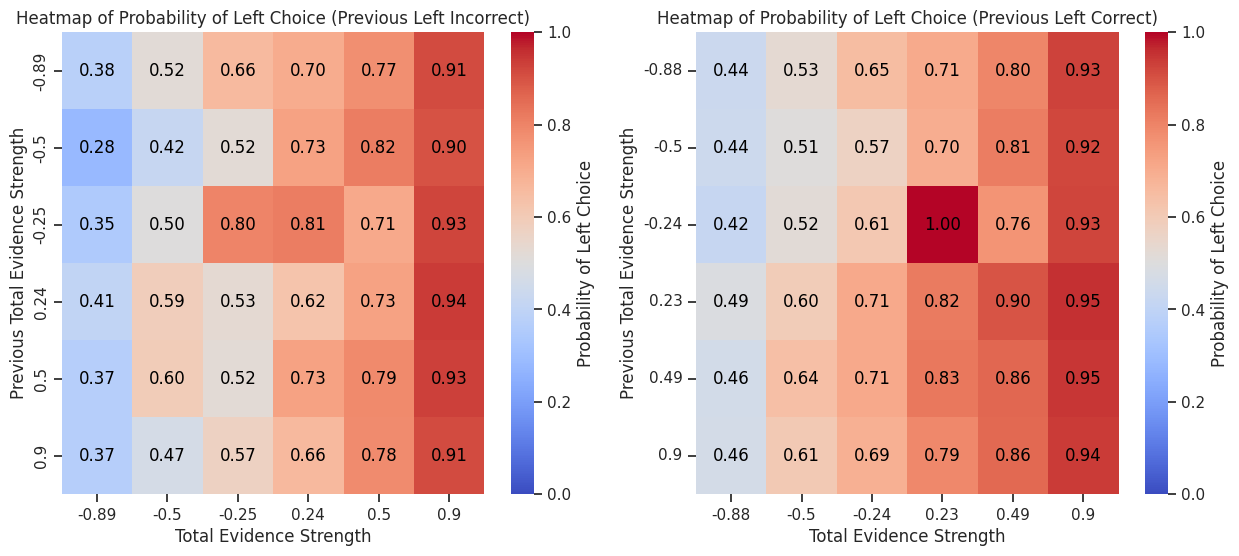

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i in df_test_auditory[(df_test_auditory['previous_port_before_stimulus'] == 'left')].groupby('previous_correct_numeric'):
    df_preleft = i[1]
    bins=6
    bin_groups = pd.cut(df_preleft['total_evidence_strength'], bins=bins)
    labels = df_preleft['total_evidence_strength'].groupby(bin_groups).mean()
    df_preleft['total_evidence_strength_binned'] = pd.cut(df_preleft['total_evidence_strength'], bins=bins, labels=labels).astype(float)
    df_preleft['total_evidence_strength_binned'] = df_preleft['total_evidence_strength_binned'].apply(lambda x: round(x, 2))
    for mouse in df_preleft['subject'].unique():
        for session in df_preleft[df_preleft.subject == mouse]['session'].unique():
            df_mouse_session = df_preleft[np.logical_and(df_preleft['subject'] == mouse, df_preleft['session'] == session)]
            df_mouse_session['previous_total_evidence_strength_binned'] = df_mouse_session['total_evidence_strength_binned'].shift(1, fill_value=np.nan)
            df_preleft.loc[df_mouse_session.index, 'previous_total_evidence_strength_binned'] = df_mouse_session['previous_total_evidence_strength_binned']
    pivot_table = df_preleft.pivot_table(
        index='previous_total_evidence_strength_binned',
        columns='total_evidence_strength_binned',
        values='first_choice_numeric',
        aggfunc='mean',
        observed=True
    )
    # plot the heatmap
    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"}, ax=axes[i[0]])
    axes[i[0]].set_xlabel("Total Evidence Strength")
    axes[i[0]].set_ylabel("Previous Total Evidence Strength")
    axes[i[0]].set_title("Heatmap of Probability of Left Choice (Previous Left {})".format('Correct' if i[0] == 1 else 'Incorrect'))
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.show()

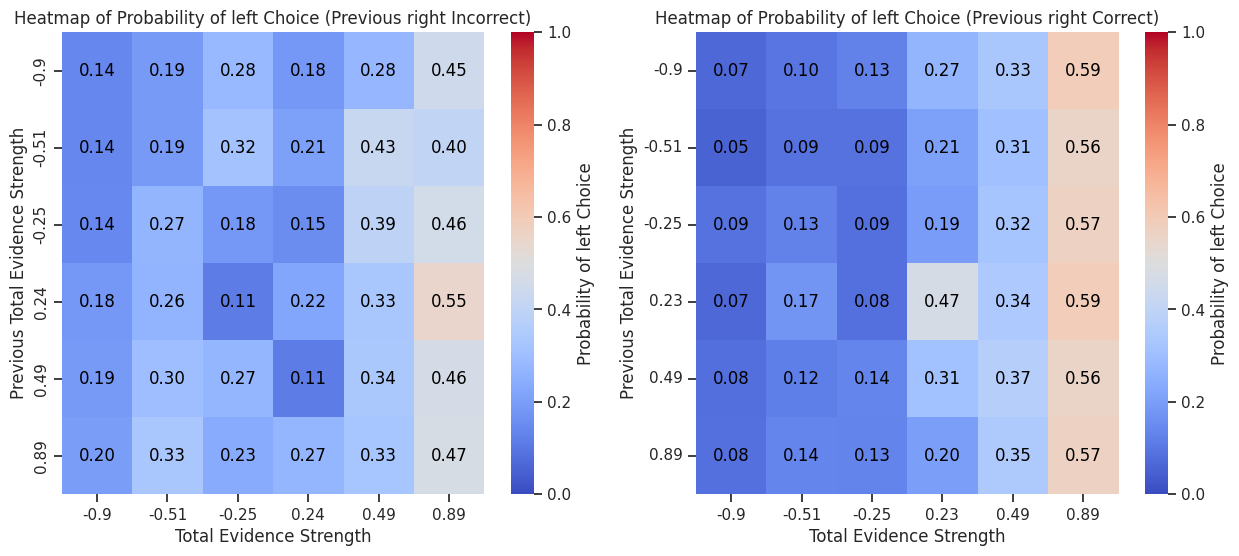

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i in df_test_auditory[(df_test_auditory['previous_port_before_stimulus'] == 'right')].groupby('previous_correct_numeric'):
    df_preright = i[1]
    bins=6
    bin_groups = pd.cut(df_preright['total_evidence_strength'], bins=bins)
    labels = df_preright['total_evidence_strength'].groupby(bin_groups).mean()
    df_preright['total_evidence_strength_binned'] = pd.cut(df_preright['total_evidence_strength'], bins=bins, labels=labels).astype(float)
    df_preright['total_evidence_strength_binned'] = df_preright['total_evidence_strength_binned'].apply(lambda x: round(x, 2))
    for mouse in df_preright['subject'].unique():
        for session in df_preright[df_preright.subject == mouse]['session'].unique():
            df_mouse_session = df_preright[np.logical_and(df_preright['subject'] == mouse, df_preright['session'] == session)]
            df_mouse_session['previous_total_evidence_strength_binned'] = df_mouse_session['total_evidence_strength_binned'].shift(1, fill_value=np.nan)
            df_preright.loc[df_mouse_session.index, 'previous_total_evidence_strength_binned'] = df_mouse_session['previous_total_evidence_strength_binned']
    pivot_table = df_preright.pivot_table(
        index='previous_total_evidence_strength_binned',
        columns='total_evidence_strength_binned',
        values='first_choice_numeric',
        aggfunc='mean',
        observed=True
    )
    # plot the heatmap
    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"}, ax=axes[i[0]])
    axes[i[0]].set_xlabel("Total Evidence Strength")
    axes[i[0]].set_ylabel("Previous Total Evidence Strength")
    axes[i[0]].set_title("Heatmap of Probability of left Choice (Previous right {})".format('Correct' if i[0] == 1 else 'Incorrect'))
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.show()

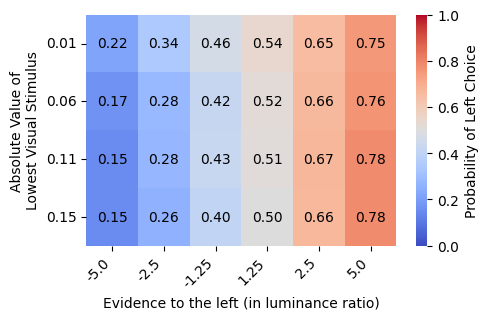

In [ ]:
# let's use the absolute value of the lowest visual stimulus as a proxy for the brightness of the visual stimulus
df_test_visual['visual_stimulus_lowest'] = df_test_visual['visual_stimulus'].apply(lambda x: abs(eval(x)[0]) if eval(x)[0] < eval(x)[1] else abs(eval(x)[1]))
# visual stimulus ratio to only two decimal places
df_test_visual['visual_stimulus_ratio'] = df_test_visual['visual_stimulus_ratio'].apply(lambda x: round(x, 2))
# create 10 bins for the absolute value of the lowest visual stimulus
min_value = df_test_visual['visual_stimulus_lowest'].min()
max_value = df_test_visual['visual_stimulus_lowest'].max()
bins = np.linspace(min_value, max_value, 5)
df_test_visual['visual_stimulus_lowest_binned'] = pd.cut(df_test_visual['visual_stimulus_lowest'], bins=bins, labels=[f"{b:.2f}" for b in bins[:-1]])
# create a pivot table with the visual stimulus ratio and absolute value of the lowest visual stimulus
pivot_table_abs = df_test_visual.pivot_table(
    index='visual_stimulus_lowest_binned',
    columns='visual_stimulus_ratio',
    values='first_choice_numeric',
    aggfunc='mean',
    observed=True
)
# plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(pivot_table_abs, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'}, vmin=0, vmax=1, annot_kws={"color": "black"})
plt.xlabel("Evidence to the left (in luminance ratio)")
plt.ylabel("Absolute Value of\nLowest Visual Stimulus")
# plt.title("Heatmap of Probability of Left Choice")
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
# save in Desktop
# plt.savefig('/home/hmv/lab/heatmap_visual_stimulus.pdf', bbox_inches='tight')
plt.show()

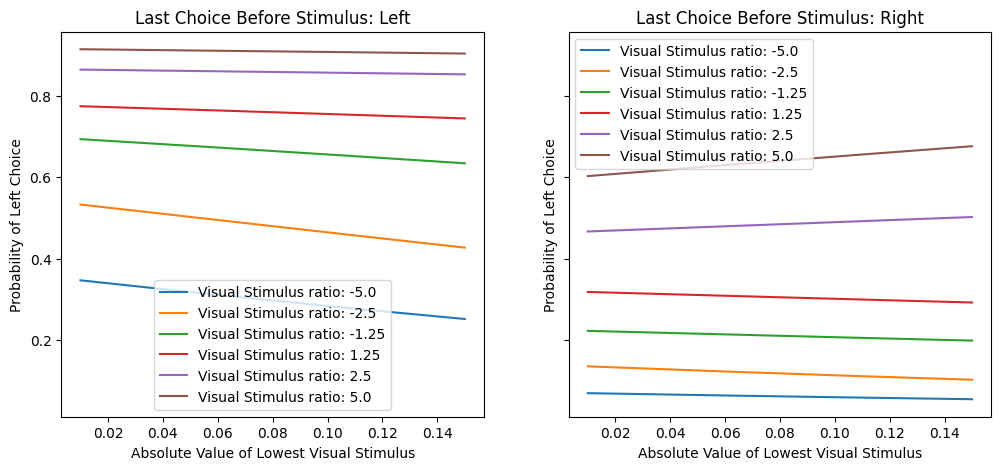

In [ ]:
# transform visual_stimulus_lowest_binned to a numeric value for plotting
df_test_visual['visual_stimulus_lowest_binned_num'] = pd.to_numeric(df_test_visual['visual_stimulus_lowest_binned'], errors='coerce')

# make two plots, one for when the animals comes from the left and one for when it comes from the right
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot for when the animal comes from the left
for ax, side in zip(axs.ravel(), ['left', 'right']):
    df_side = df_test_visual[df_test_visual['previous_port_before_stimulus'] == side]
    for i in df_side.groupby('visual_stimulus_ratio'):
        df_i = i[1].sort_values(by='visual_stimulus_lowest_binned_num')
        # drop nan
        df_i = df_i.dropna(subset=['visual_stimulus_lowest_binned_num'])
        X = df_i['visual_stimulus_lowest_binned_num'].values.reshape(-1, 1)
        y = df_i['first_choice_numeric'].values.astype(int)
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        ax.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    ax.set_xlabel("Absolute Value of Lowest Visual Stimulus")
    ax.set_ylabel("Probability of Left Choice")
    ax.legend()
    ax.set_title(f"Last Choice Before Stimulus: {side.capitalize()}")
plt.show()

# compare the model

## find the optimal parameters of time kernel

In [236]:
comb_dict = utils.verify_params_time_kernel(dic = df_dic_hard_vis, y='first_choice_numeric')
sorted_items = sorted(comb_dict.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items[:5]

Optimization terminated successfully.
         Current function value: 0.674721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586728
  

[((1, 1), np.float64(0.6696054821196092)),
 ((1, 4), np.float64(0.6696054821196092)),
 ((1, 5), np.float64(0.6696054821196091)),
 ((1, 6), np.float64(0.6696054821196091)),
 ((1, 7), np.float64(0.6696054821196091))]

In [245]:
comb_dict_vis_correct = utils.verify_params_time_kernel(dic = df_dic_hard_vis, y='correct_numeric', max_lag_range=range(1,100), tau_range=range(1,2))
sorted_items_vis_correct = sorted(comb_dict_vis_correct.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items_vis_correct[:5]

Optimization terminated successfully.
         Current function value: 0.650753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630596
  

[((28, 1), np.float64(0.09396251828033034)),
 ((27, 1), np.float64(0.09384973101015157)),
 ((26, 1), np.float64(0.09381889076940803)),
 ((29, 1), np.float64(0.09371278713157269)),
 ((30, 1), np.float64(0.09350662222848524))]

In [237]:
comb_dict = utils.verify_params_time_kernel(dic = df_dic_hard_aud, y='first_choice_numeric')
sorted_items = sorted(comb_dict.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items[:5]

Optimization terminated successfully.
         Current function value: 0.667147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676244
  

[((1, 1), np.float64(0.4912211182840647)),
 ((1, 3), np.float64(0.4912211182840647)),
 ((1, 4), np.float64(0.4912211182840647)),
 ((1, 5), np.float64(0.4912211182840647)),
 ((1, 6), np.float64(0.4912211182840647))]

In [246]:
comb_dict_aud_correct = utils.verify_params_time_kernel(dic = df_dic_hard_aud, y='correct_numeric', max_lag_range=range(1,100), tau_range=range(1,2))
sorted_items_aud_correct = sorted(comb_dict_aud_correct.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_items_aud_correct[:5]

Optimization terminated successfully.
         Current function value: 0.686810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.460174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566422
  

[((96, 1), np.float64(0.13394129509700112)),
 ((99, 1), np.float64(0.13390445384288524)),
 ((94, 1), np.float64(0.1338912598589828)),
 ((95, 1), np.float64(0.13388465549950532)),
 ((97, 1), np.float64(0.13388368377952076))]

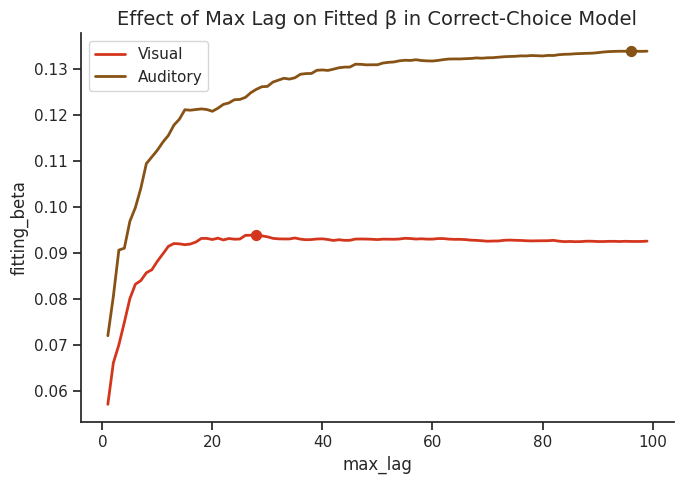

In [284]:
x_vis, y_vis = zip(*sorted(comb_dict_vis_correct.items()))
x_aud, y_aud = zip(*sorted(comb_dict_aud_correct.items()))

x_peak_vis = max(comb_dict_vis_correct, key=comb_dict_vis_correct.get)
y_peak_vis = comb_dict_vis_correct[x_peak_vis]

x_peak_aud = max(comb_dict_aud_correct, key=comb_dict_aud_correct.get)
y_peak_aud = comb_dict_aud_correct[x_peak_aud]

plt.figure(figsize=(7,5))
plt.plot([x[0] for x in x_vis], y_vis, color="#D4361D", label='Visual', linewidth=2)
plt.scatter(x_peak_vis[0], y_peak_vis, color='#D4361D', s=50, zorder=3)

plt.plot([x[0] for x in x_aud], y_aud, color="#875215", label='Auditory', linewidth=2)
plt.scatter(x_peak_aud[0], y_peak_aud, color='#875215', s=50, zorder=3)

plt.xlabel('max_lag', fontsize=12)
plt.ylabel('fitting_beta', fontsize=12)
plt.title('Effect of Max Lag on Fitted β in Correct-Choice Model', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
window_size = 100
df_test_visual = pd.DataFrame()
df_test_auditory = pd.DataFrame()
for mouse in df_dic_hard_vis:
    for session in df_dic_hard_vis[mouse]['session'].unique():
        df_mouse_session = df_dic_hard_vis[mouse][df_dic_hard_vis[mouse]['session'] == session]
        df_mouse_session['performance_trial'] = df_mouse_session['correct'].rolling(window_size, center=True, min_periods=2).mean()
        df_dic_hard_vis[mouse].loc[df_mouse_session.index, 'performance_trial'] = df_mouse_session['performance_trial'].values
    df_test_visual = pd.concat([df_test_visual, df_dic_hard_vis[mouse]], ignore_index=True)
for mouse in df_dic_hard_aud:
    for session in df_dic_hard_aud[mouse]['session'].unique():
        df_mouse_session = df_dic_hard_aud[mouse][df_dic_hard_aud[mouse]['session'] == session]
        df_mouse_session['performance_trial'] = df_mouse_session['correct'].rolling(window_size, center=True, min_periods=2).mean()
        df_dic_hard_aud[mouse].loc[df_mouse_session.index, 'performance_trial'] = df_mouse_session['performance_trial'].values
    df_test_auditory = pd.concat([df_test_auditory, df_dic_hard_aud[mouse]], ignore_index=True)

In [ ]:
for mouse in df_dic_hard_vis:
    plt.plot(df_dic_hard_vis['performance_trial'].)

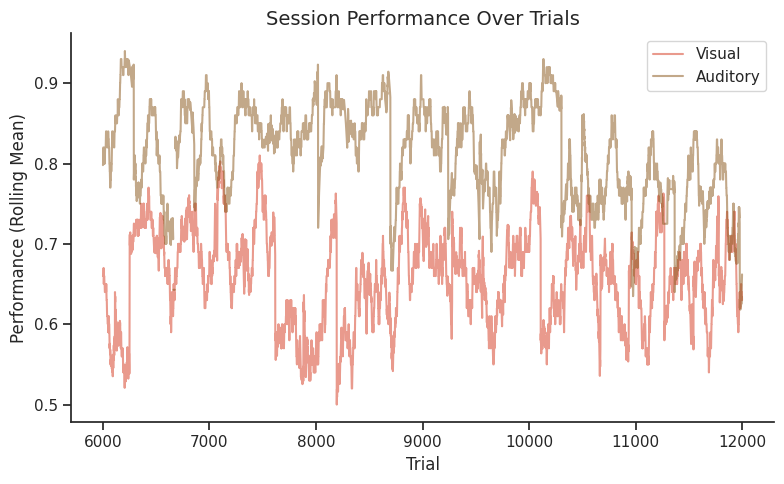

In [172]:
plt.figure(figsize=(8, 5))
zoomin_index = slice(6000, 12000)
plt.plot(df_test_visual['performance_trial'].loc[zoomin_index], label='Visual', color='#D4361D', alpha=0.5)
plt.plot(df_test_auditory['performance_trial'].loc[zoomin_index], label='Auditory', color='#875215', alpha=0.5)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('Performance (Rolling Mean)', fontsize=12)
plt.title('Session Performance Over Trials', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
get_day_performance

In [310]:
max_lag_vis_correct = x_peak_vis[0]
max_lag_aud_correct = x_peak_aud[0]

df_test_visual = pd.DataFrame()
for mouse in df_dic_hard_vis:
    df_dic_hard_vis[mouse] = dft.get_time_kernel_impact(df_dic_hard_vis[mouse], y='correct_numeric', max_lag=max_lag_vis_correct, tau=1)
    df_test_visual = pd.concat([df_test_visual, df_dic_hard_vis[mouse]], ignore_index=True)

df_test_auditory = pd.DataFrame()
for mouse in df_dic_hard_aud:
    df_dic_hard_aud[mouse] = dft.get_time_kernel_impact(df_dic_hard_aud[mouse], y='correct_numeric', max_lag=max_lag_aud_correct, tau=1)
    df_test_auditory = pd.concat([df_test_auditory, df_dic_hard_aud[mouse]], ignore_index=True)

## filter the correlated values

         Current function value: 0.566772
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.586231
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.571521
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.567277
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.576284
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.582645
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.566831
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
         Current functio

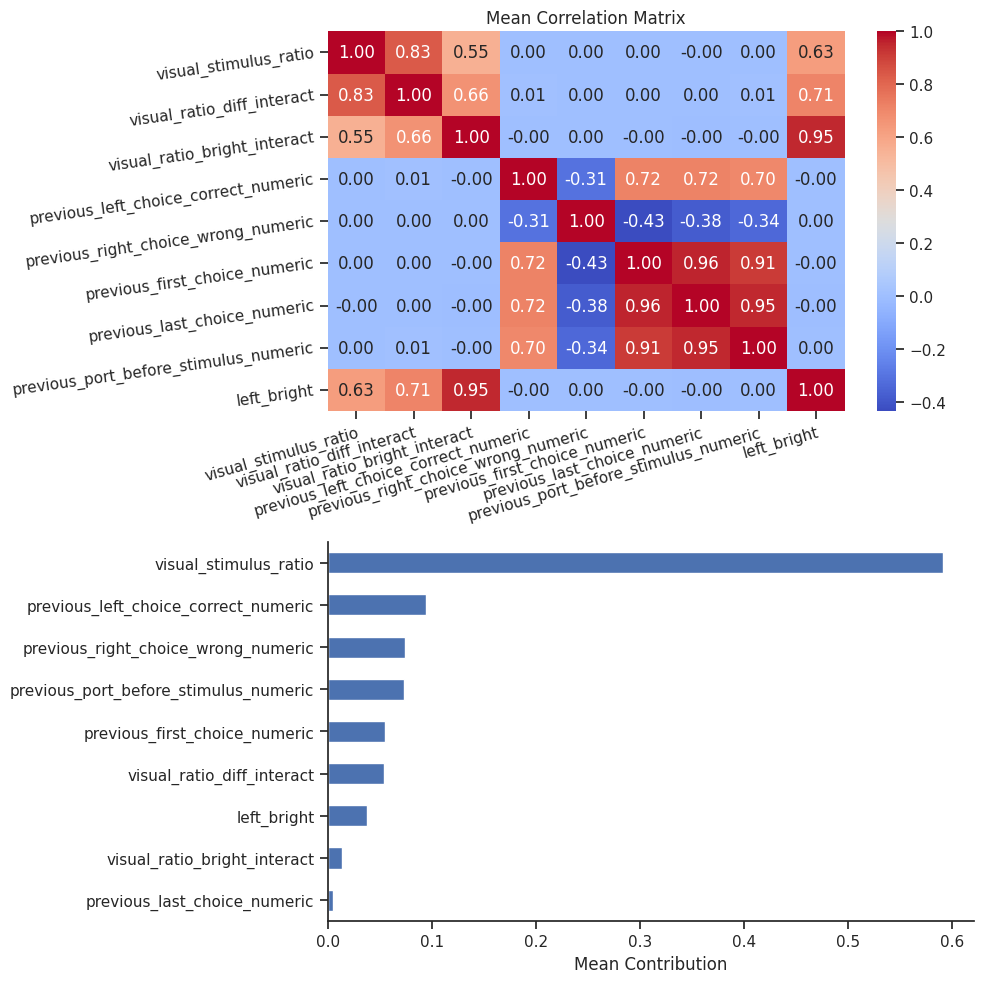

In [285]:
X = ['visual_stimulus_ratio',
    'visual_ratio_diff_interact',
    'visual_ratio_bright_interact', 
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'previous_port_before_stimulus_numeric',
    'left_bright'
    ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_vis, X = X, y='first_choice_numeric')
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

Optimization terminated successfully.
         Current function value: 0.574372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481220
  

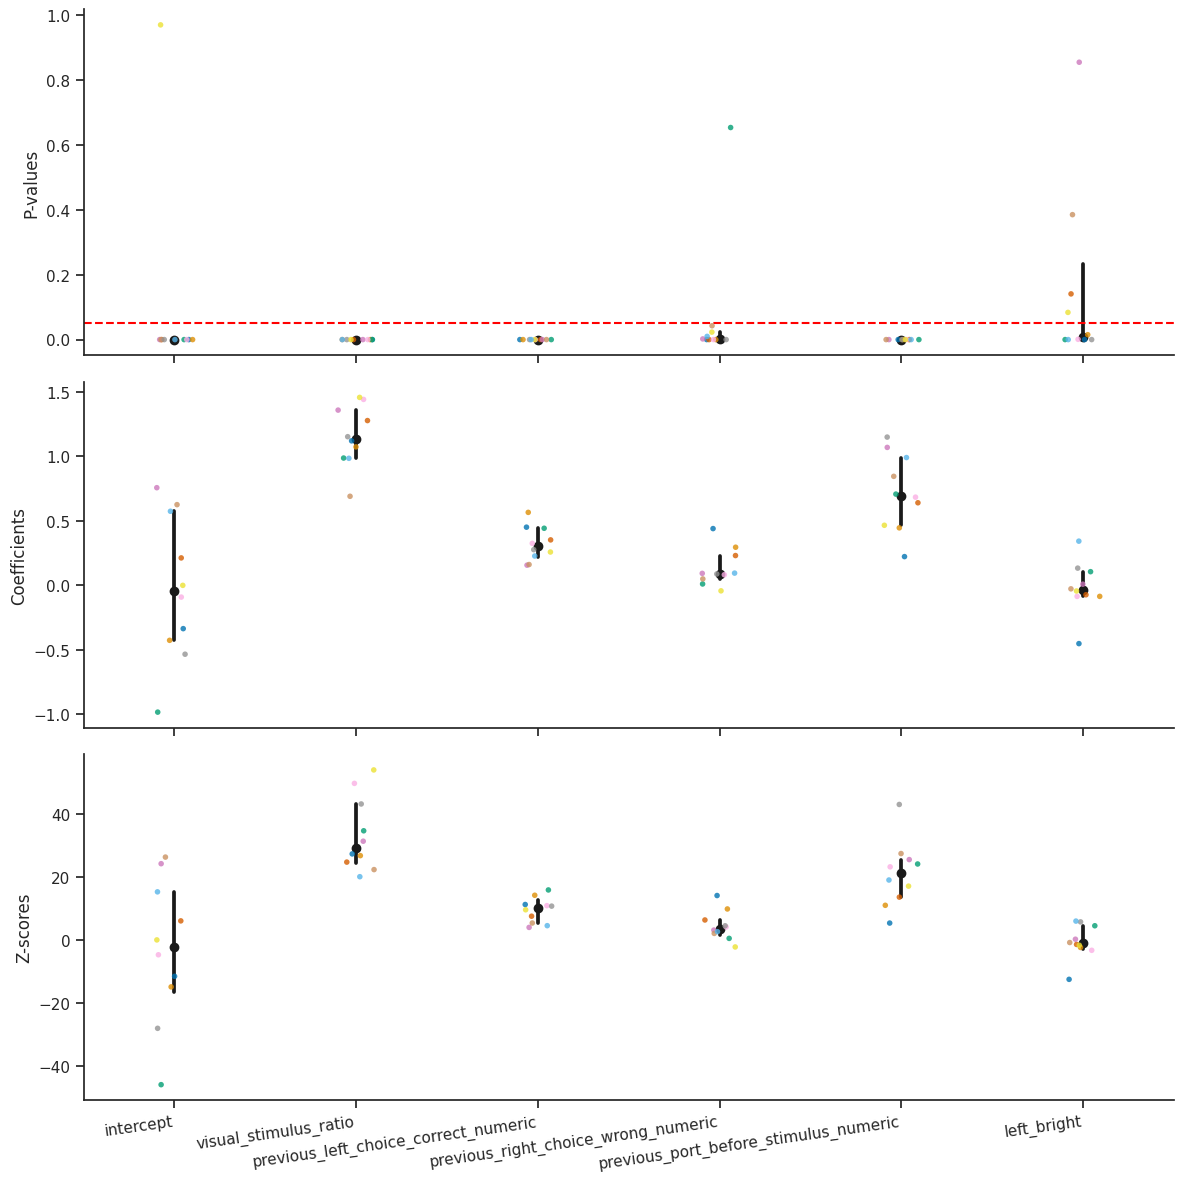

In [ ]:
X = ['visual_stimulus_ratio',
    # 'visual_ratio_diff_interact',
    # 'visual_ratio_bright_interact', 
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    # 'previous_first_choice_numeric', 
    # 'previous_last_choice_numeric', 
    'previous_port_before_stimulus_numeric',
    'left_bright'
    ]
plots.plot_model_vars_params_compare(dic_fit=df_dic_hard_vis, X=X, y='first_choice_numeric')

         Current function value: 0.630892
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.647778
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.630912
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.631556
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.630894
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.631550
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.630997
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated 

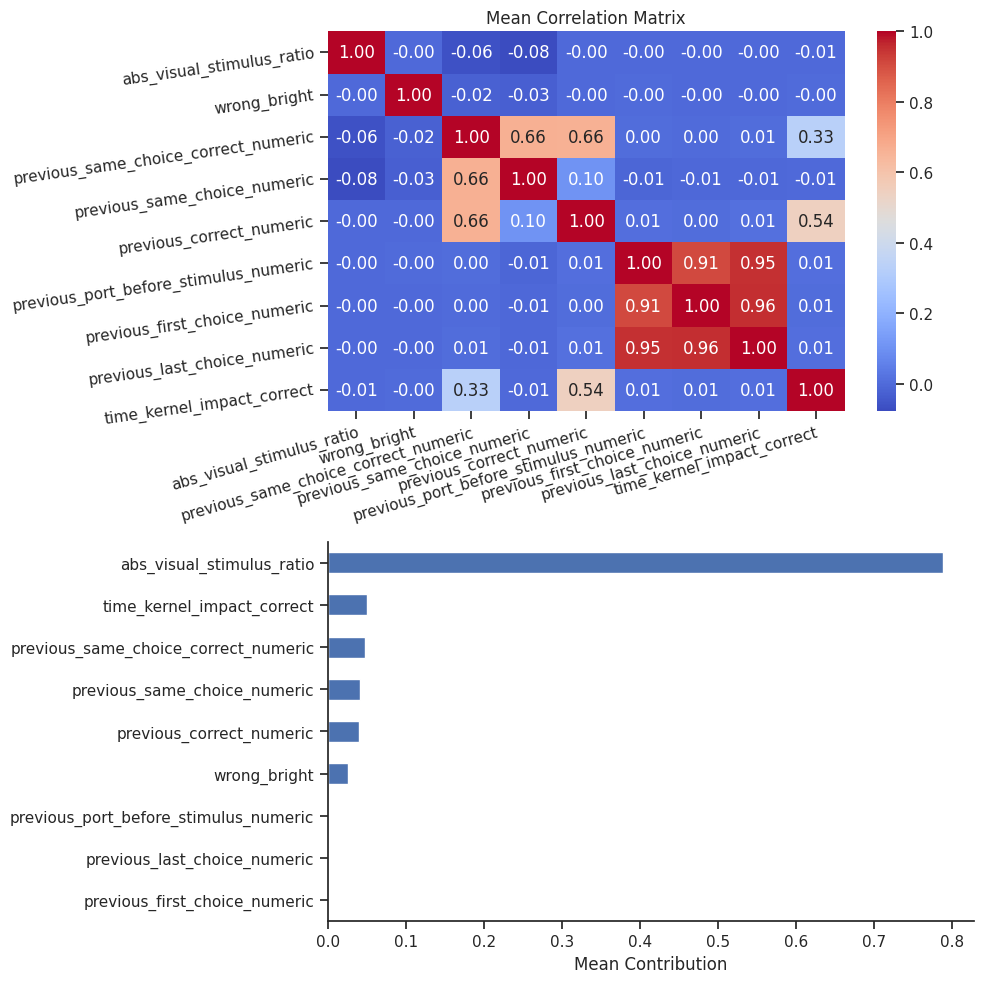

In [286]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    'previous_port_before_stimulus_numeric', 
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric', 
    'time_kernel_impact_correct'
        ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_vis, X = X, y='correct_numeric', max_lag=max_lag_vis_correct, tau=1)
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

Optimization terminated successfully.
         Current function value: 0.631287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589358
  

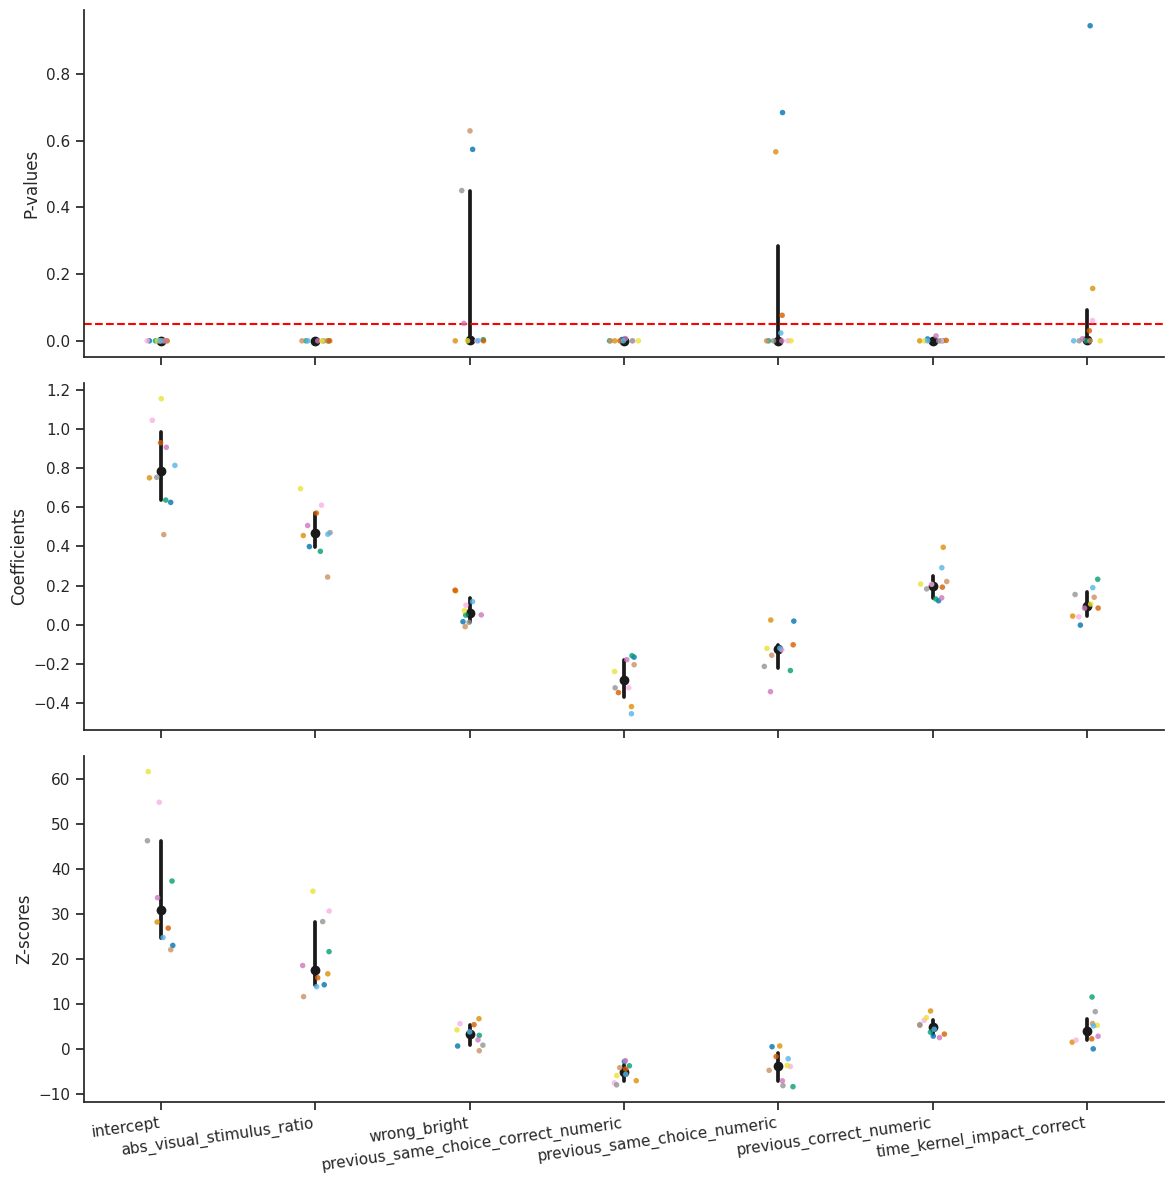

In [344]:
X = ['abs_visual_stimulus_ratio',
    'wrong_bright', 
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    # 'previous_port_before_stimulus_numeric', 
    # 'previous_first_choice_numeric', 
    # 'previous_last_choice_numeric', 
    'time_kernel_impact_correct'
        ]
plots.plot_model_vars_params_compare(dic_fit=df_dic_hard_vis, X=X, y='correct_numeric')

         Current function value: 0.631223
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.631223
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.631223
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.631226
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.633191
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.631224
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.631228
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated 

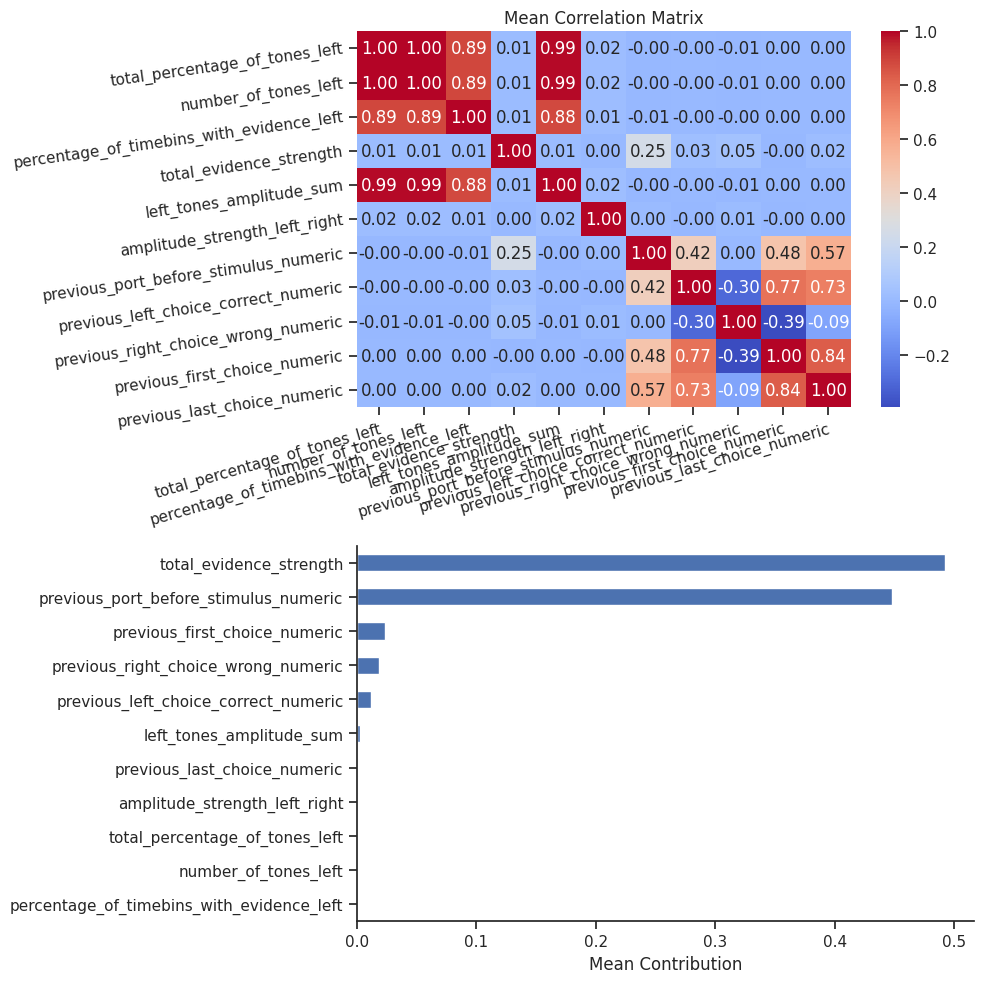

In [312]:
X = ['total_percentage_of_tones_left',
    'number_of_tones_left',
    'percentage_of_timebins_with_evidence_left', 
    'total_evidence_strength', 
    'left_tones_amplitude_sum',
    'amplitude_strength_left_right',
    'previous_port_before_stimulus_numeric',
    'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    'previous_first_choice_numeric', 
    'previous_last_choice_numeric'
    ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_aud, X = X, y='first_choice_numeric')
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

Optimization terminated successfully.
         Current function value: 0.638068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.279850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505998
  

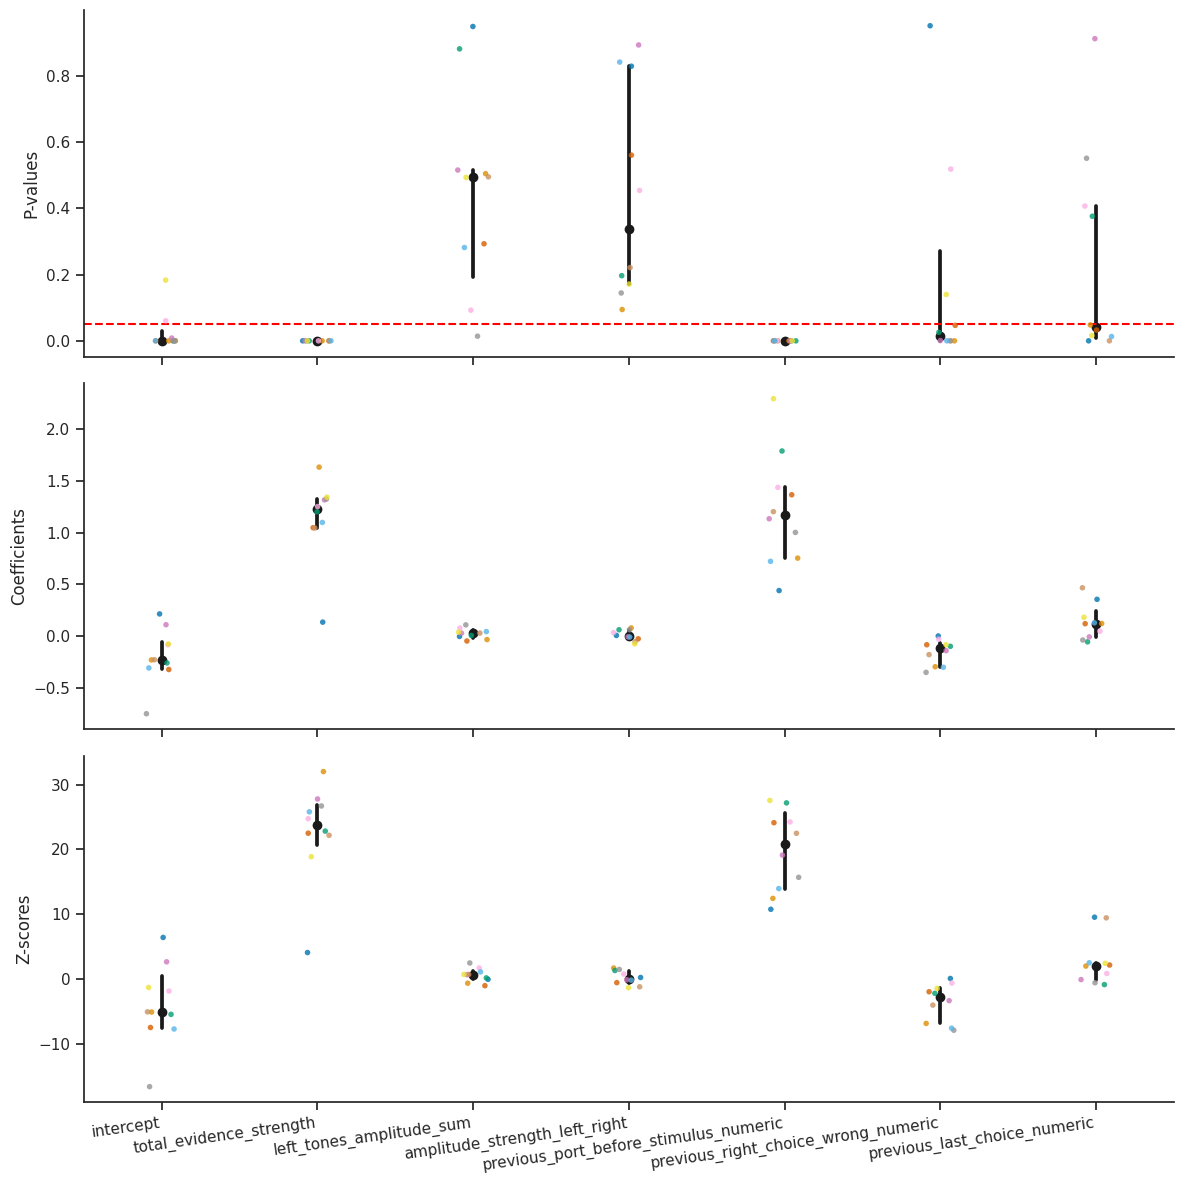

In [346]:
X = [
    # 'total_percentage_of_tones_left',
    # 'number_of_tones_left',
    # 'percentage_of_timebins_with_evidence_left', 
    'total_evidence_strength', 
    'left_tones_amplitude_sum',
    'amplitude_strength_left_right',
    'previous_port_before_stimulus_numeric',
    # 'previous_left_choice_correct_numeric',
    'previous_right_choice_wrong_numeric',
    # 'previous_first_choice_numeric', 
    'previous_last_choice_numeric'
    ]
plots.plot_model_vars_params_compare(dic_fit=df_dic_hard_aud, X=X, y='first_choice_numeric')

         Current function value: 0.666111
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.666111
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 0.666111
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.666633
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.666389
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.666111
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.666112
         Iterations: 35
         Functio

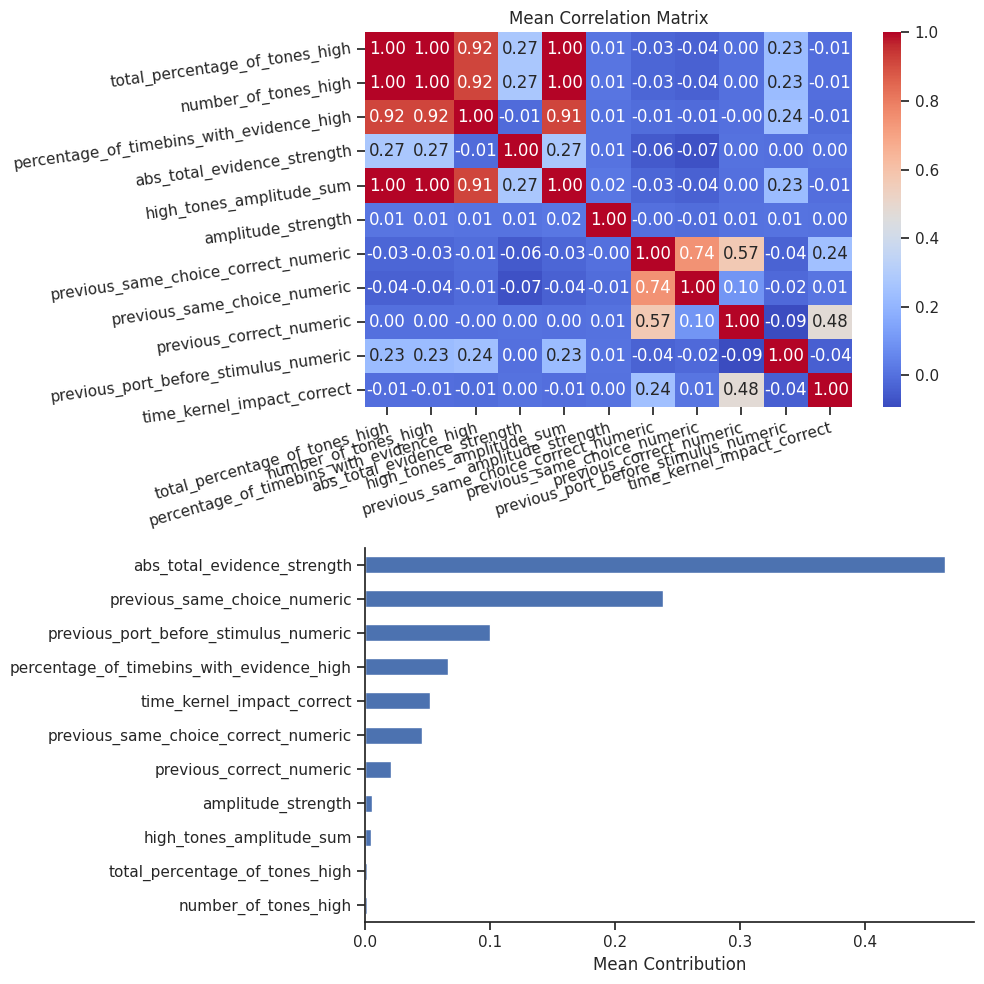

In [311]:
X = ['total_percentage_of_tones_high',
    'number_of_tones_high',
    'percentage_of_timebins_with_evidence_high', 
    'abs_total_evidence_strength', 
    'high_tones_amplitude_sum',
    'amplitude_strength',
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    'previous_correct_numeric', 
    'previous_port_before_stimulus_numeric', 
    'time_kernel_impact_correct'
    ]
corr_mat_list, norm_contribution_df = utils.filter_variables_for_model(dic_fit=df_dic_hard_aud, X = X, y='correct_numeric', max_lag=max_lag_aud_correct, tau=1)
plots.plot_filter_model_variables(corr_mat_list=corr_mat_list, norm_contribution_df=norm_contribution_df)

Optimization terminated successfully.
         Current function value: 0.669645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.465956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.581424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559419
  

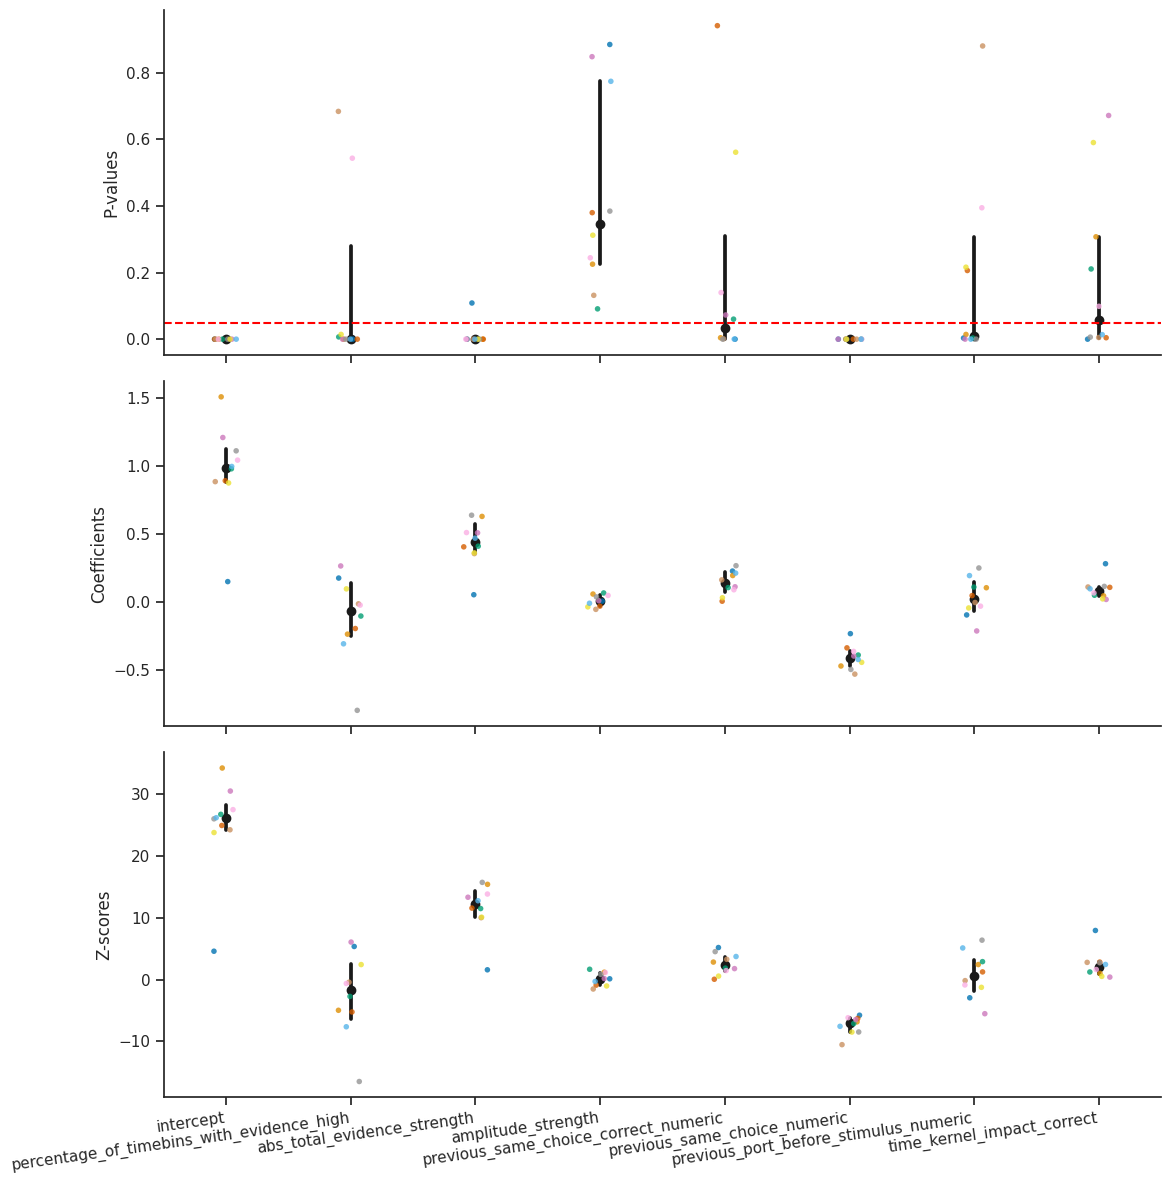

In [348]:
X = [
    # 'total_percentage_of_tones_high',
    # 'number_of_tones_high',
    'percentage_of_timebins_with_evidence_high', 
    'abs_total_evidence_strength', 
    # 'high_tones_amplitude_sum',
    'amplitude_strength',
    'previous_same_choice_correct_numeric', 
    'previous_same_choice_numeric', 
    # 'previous_correct_numeric', 
    'previous_port_before_stimulus_numeric', 
    'time_kernel_impact_correct'
    ]
plots.plot_model_vars_params_compare(dic_fit=df_dic_hard_aud, X=X, y='correct_numeric')

I kept what you did for comparison here

In [ ]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_ratio'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")
plt.show()

# change with time

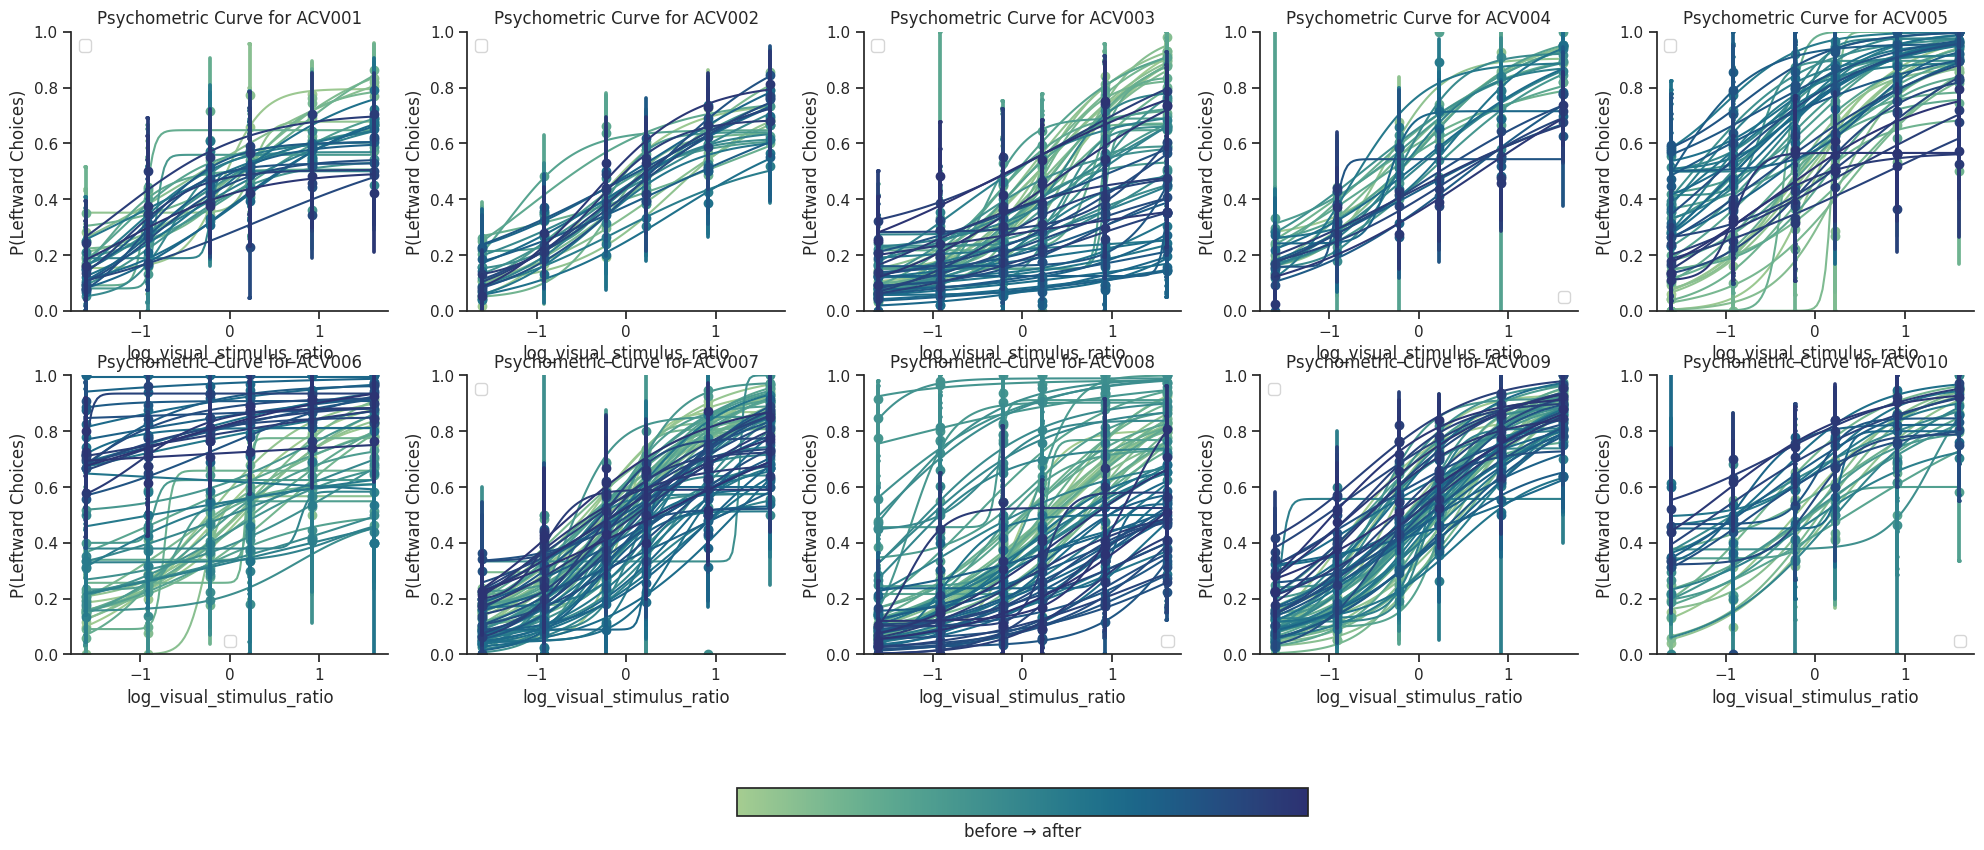

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for df_name, df, n in zip(df_dic_hard_vis.keys(), df_dic_hard_vis.values(), range(len(df_dic_hard_vis))):
    row = n // 5
    col = n % 5
    for session, color in zip(df['session'].unique(), sns.color_palette("crest", len(df['session'].unique()))):
        df_session = df[df['session'] == session]
        plots.psychometric_plot(df_session, x='visual_stimulus_ratio', y='first_choice_numeric',ax=ax[row, col], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': ''})
    ax[row, col].set_title(f"Psychometric Curve for {df_name}")
plt.tight_layout()
# Add a colorbar to indicate the session
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("crest", as_cmap=True)), orientation='horizontal', ax=ax, shrink=0.3)
cbar.set_ticks([])
cbar.set_label('before → after')
plt.legend()
plt.show()

In [391]:
def plot_model_param_evolution(
    df_dic: dict,
    x_col: str,
    y_col: str,
    block_size: int = 1000,
    title: str = "Model parameter evolution over trial blocks",
    figsize: tuple = (14, 4),
    palette: str = "colorblind"
):
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    colors = sns.color_palette(palette, len(df_dic))

    lapse_left_dict, lapse_right_dict, slope_dict, bias_dict = {}, {}, {}, {}

    for (df_name, df), color in zip(df_dic.items(), colors):
        df = df.copy()
        df["trial_group"] = np.arange(len(df)) // block_size

        lapse_left, lapse_right, slope, bias = [], [], [], []

        for group in df["trial_group"].unique():
            df_group = df[df["trial_group"] == group]
            _, params = utils.fit_lapse_logistic_independent(df_group[x_col], df_group[y_col])
            lapse_left.append(params[0])
            lapse_right.append(params[1])
            slope.append(params[2])
            bias.append(params[3])

        lapse_left_dict[df_name] = lapse_left
        lapse_right_dict[df_name] = lapse_right
        slope_dict[df_name] = slope
        bias_dict[df_name] = bias

        for a, param, name in zip(ax, [lapse_left, lapse_right, slope, bias],
                                  ["Lapse Left", "Lapse Right", "Beta", "X0"]):
            a.plot(param, c=color, alpha=0.5)
            a.set_ylabel(name)

    lapse_left_df = pd.DataFrame({k: pd.Series(v) for k, v in lapse_left_dict.items()})
    lapse_right_df = pd.DataFrame({k: pd.Series(v) for k, v in lapse_right_dict.items()})
    slope_df = pd.DataFrame({k: pd.Series(v) for k, v in slope_dict.items()})
    bias_df = pd.DataFrame({k: pd.Series(v) for k, v in bias_dict.items()})

    for a, df, name in zip(ax,
                           [lapse_left_df, lapse_right_df, slope_df, bias_df],
                           ["Lapse Left", "Lapse Right", "Beta", "X0"]):
        a.plot(df.mean(axis=1), color="k", linestyle="-", label="Overall Mean")
        a.set_xlabel(f"{block_size}-Trial Blocks")
        a.legend(frameon=False)
        a.set_title(name)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


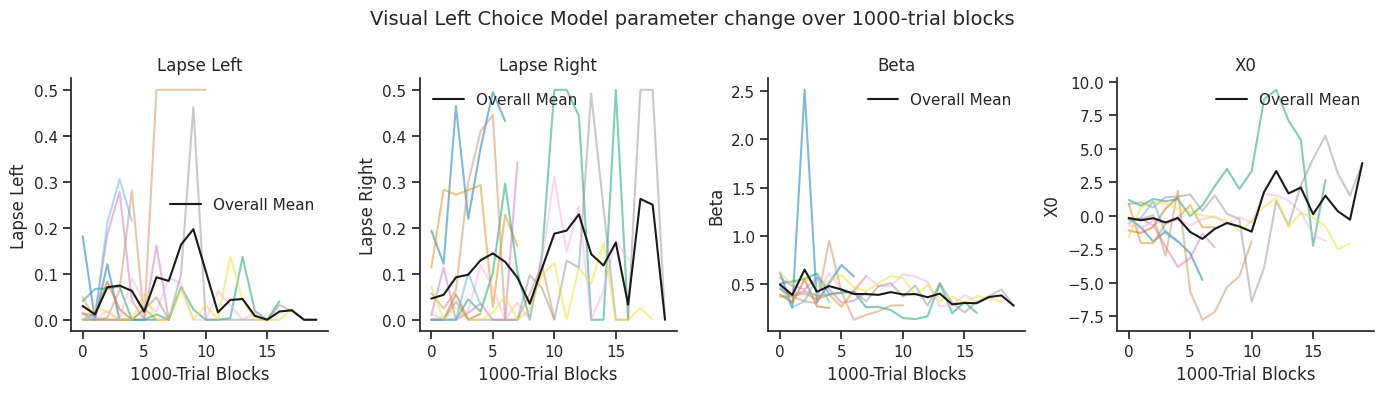

In [ ]:
plot_model_param_evolution(
    df_dic=df_dic_hard_vis,
    x_col="visual_stimulus_ratio",
    y_col="first_choice_numeric",
    title="Visual Left Choice Model parameter change over 1000-trial blocks"
)


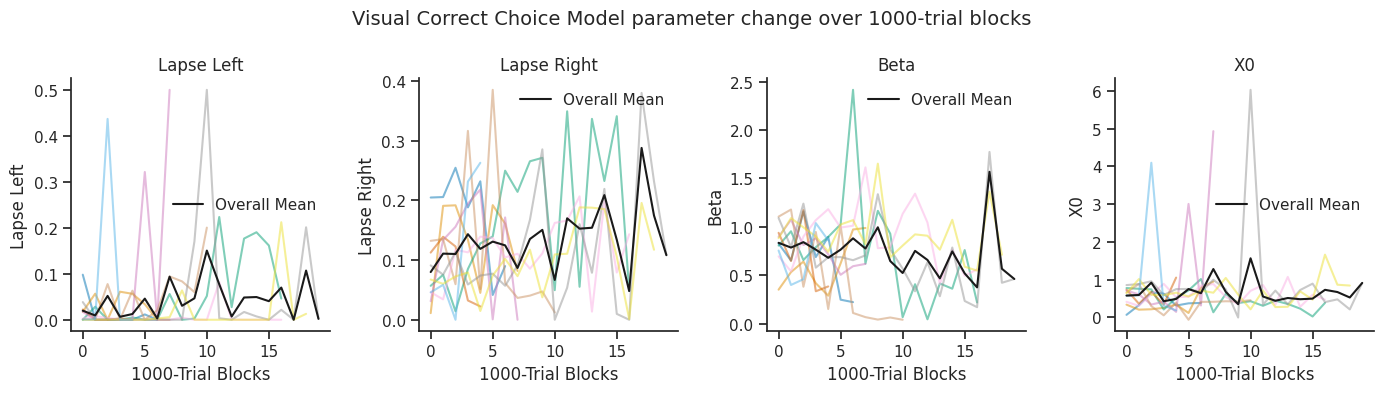

In [ ]:
plot_model_param_evolution(
    df_dic=df_dic_hard_vis,
    x_col="abs_visual_stimulus_ratio",
    y_col="correct_numeric",
    title="Visual Correct Choice Model parameter change over 1000-trial blocks"
)

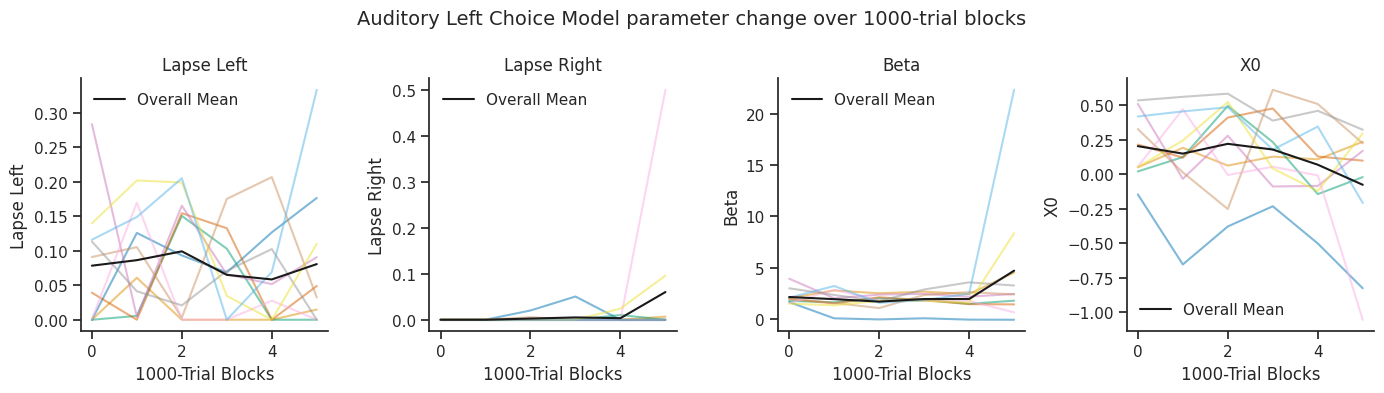

In [ ]:
plot_model_param_evolution(
    df_dic=df_dic_hard_aud,
    x_col="total_evidence_strength",
    y_col="first_choice_numeric",
    title="Auditory Left Choice Model parameter change over 1000-trial blocks"
)

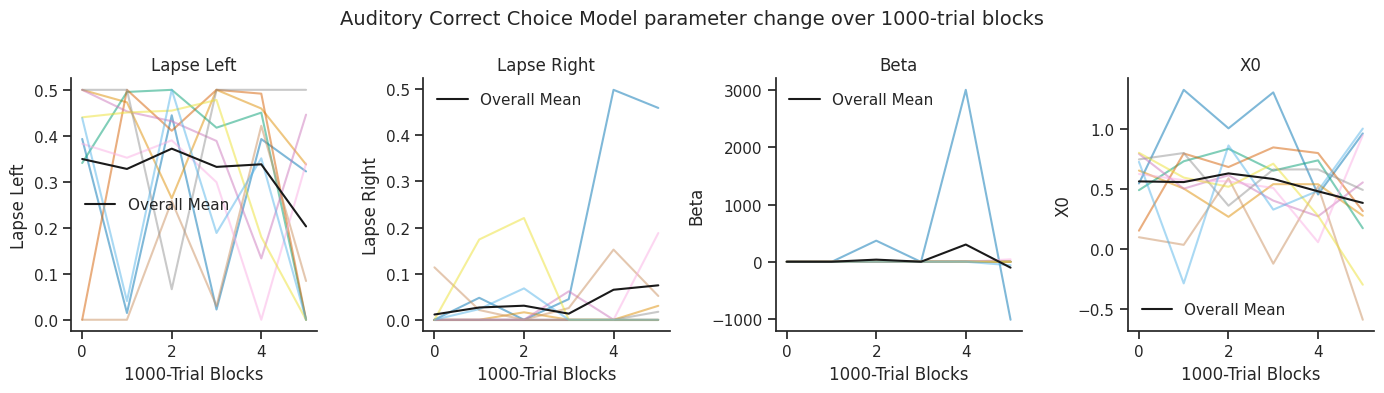

In [396]:
plot_model_param_evolution(
    df_dic=df_dic_hard_aud,
    x_col="abs_total_evidence_strength",
    y_col="correct_numeric",
    title="Auditory Correct Choice Model parameter change over 1000-trial blocks"
)

# timebin evidence of auditory task

In [ ]:
sound_properties_for_cot_mat = {
    "duration": .5,
    "high_amplitude_mean": 70,
    "low_amplitude_mean": 70,
    "amplitude_std": 2,
    "subduration": 0.03,
    "suboverlap": 0.01,
    "ambiguous_beginning_time": 0.05,
}

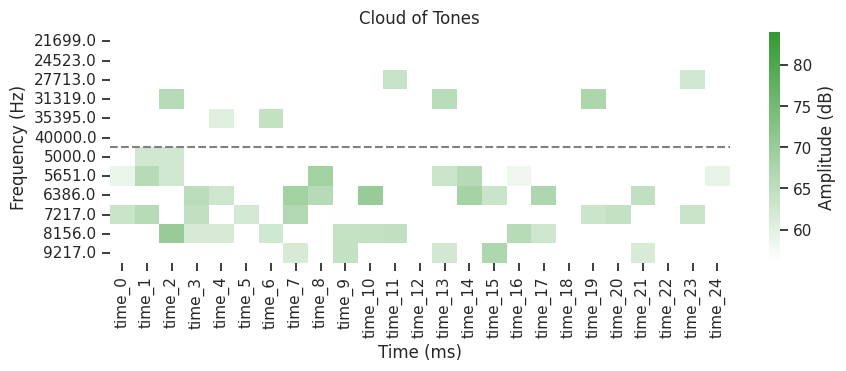

In [418]:
# auditory stimuli plot
aud_stim_sample = df_dic_hard_aud['ACV001']['auditory_stimulus'][67103]
high_mat = pd.DataFrame(eval(aud_stim_sample)['high_tones'])[::-1]
low_mat = pd.DataFrame(eval(aud_stim_sample)['low_tones'])[::-1]

colors = [(1, 1, 1), (0.2, 0.6, 0.2)]  # White to seagreen
n_bins = 100  # Discretize the interpolation into bins
cmap_name = 'white_to_seagreen'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plt.figure(figsize=(10, 3))
mat_to_plot = pd.concat([high_mat[::-1], low_mat[::-1]])
sns.heatmap(mat_to_plot,
            cmap=cmap,
            vmin=sound_properties_for_cot_mat["low_amplitude_mean"] * .8,
            vmax=sound_properties_for_cot_mat["high_amplitude_mean"] * 1.2,
            cbar_kws={'label': 'Amplitude (dB)'})
plt.hlines(6, 0, high_mat.shape[1], colors='gray', linestyles='dashed')
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.title("Cloud of Tones")
plt.show()

In [397]:
timebin_evidence_df = pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    X = np.array([utils.get_timebin_evidence(eval(t)) for t in df['auditory_stimulus']])
    y = df['first_choice_numeric']
    X_model = sm.add_constant(X) 
    glm = sm.Logit(y, X_model).fit()
    timebin_evidence_df[df_name] = glm.params[1:]

Optimization terminated successfully.
         Current function value: 0.681204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.412728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.544119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.583000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533586
  

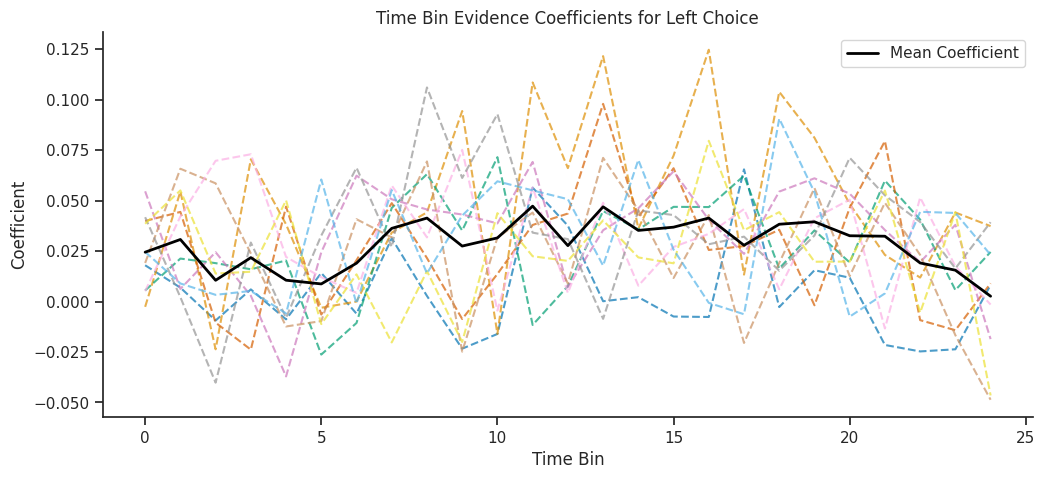

In [399]:
fig = plt.figure(figsize=(12, 5))
timebin_evidence_df.index = range(len(timebin_evidence_df))
for df_name, col, color in zip(timebin_evidence_df.columns, timebin_evidence_df, sns.color_palette("colorblind", len(timebin_evidence_df))):
    plt.plot(timebin_evidence_df[col], color=color, linestyle='--', alpha=0.7)
plt.plot(timebin_evidence_df.mean(axis=1), color='black', label='Mean Coefficient', linewidth=2)
plt.xlabel("Time Bin")
plt.ylabel("Coefficient")
plt.title("Time Bin Evidence Coefficients for Left Choice")
plt.legend()

In [402]:
timebin_evidence_df = pd.DataFrame()
for df_name, df, color in zip(df_dic_hard_aud.keys(), df_dic_hard_aud.values(), sns.color_palette("colorblind", len(df_dic_hard_aud))):
    X = np.abs(np.array([utils.get_timebin_evidence(eval(t)) for t in df['auditory_stimulus']]))
    y = df['correct_numeric']
    X_model = sm.add_constant(X) 
    glm = sm.Logit(y, X_model).fit()
    timebin_evidence_df[df_name] = glm.params[1:]

Optimization terminated successfully.
         Current function value: 0.685675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.418709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.544947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539185
  

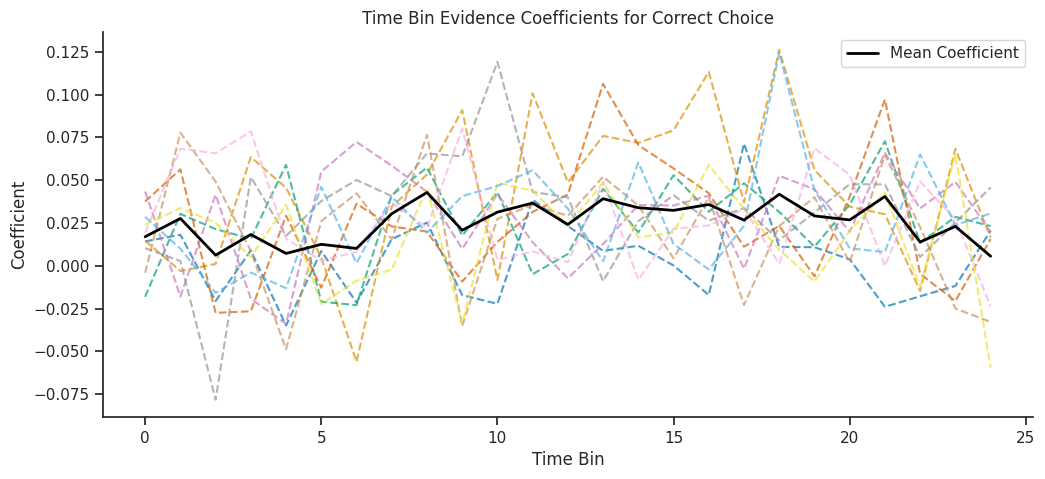

In [404]:
fig = plt.figure(figsize=(12, 5))
timebin_evidence_df.index = range(len(timebin_evidence_df))
for df_name, col, color in zip(timebin_evidence_df.columns, timebin_evidence_df, sns.color_palette("colorblind", len(timebin_evidence_df))):
    plt.plot(timebin_evidence_df[col], color=color, linestyle='--', alpha=0.7)
plt.plot(timebin_evidence_df.mean(axis=1), color='black', label='Mean Coefficient', linewidth=2)
plt.xlabel("Time Bin")
plt.ylabel("Coefficient")
plt.title("Time Bin Evidence Coefficients for Correct Choice")
plt.legend()